Trying to fit the function of https://arxiv.org/pdf/1109.0948.pdf

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
train = pd.read_csv('../input/training_set.csv')
train_meta = pd.read_csv('../input/training_set_metadata.csv')
train = train.merge(train_meta[['object_id', 'target']], how='left', on='object_id')

In [3]:
def curve_elt(t, A, t0, trise, tfall):
    if tfall <= trise:
        return 0
    res = A * np.exp(-(t - t0) / tfall) / (1 + np.exp(-(t - t0) / trise))
    return res

def curve(t, A, t0, trise, tfall):
    if tfall <= trise:
        return np.zeros(t.shape)
    res = A * np.exp(-(t - t0) / tfall) / (1 + np.exp(-(t - t0) / trise))
    return res


In [6]:
def plot_bazin(train, object_id):
    print('object_id = ', object_id)
    _passbands = ['C4','C2','C3','C1', 'k','C5']
    df = train[(train.object_id == object_id)]
    offset = 11
    t0s = []
    trises = []
    p0s = []
    bmins = []
    bmaxs = []
    xs = []
    ys = []
    y_errs = []
    mcovs = []
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    for pb in range(6):
        if 1:
            df = train[(train.object_id == object_id) & (train.passband == pb)]
            mjd_delta_prev = (df.mjd - df.mjd.shift(1)).fillna(100).values.ravel()
            mjd_delta_next = (df.mjd.shift(-1) - df.mjd).fillna(100).values.ravel()
            x_min = df.mjd.min()
            x_max = df.mjd.max()
            y_err_mean = df.flux_err.mean()
            mjd_delta_prev = np.concatenate((100 * np.ones((offset,)),
                                mjd_delta_prev,
                                100 * np.ones((offset,)),
                              ))
            mjd_delta_next = np.concatenate((100 * np.ones((offset,)),
                                mjd_delta_next,
                                100 * np.ones((offset,)),
                              ))
            x = np.concatenate((np.linspace(x_min-500, x_min -450, offset),
                                df.mjd.values,
                                np.linspace(x_max+450, x_max+500, offset),
                              ))
            y = np.concatenate((np.random.randn(offset) * y_err_mean,
                                df.flux.values,
                                np.random.randn(offset) * y_err_mean
                               ))
            y_err = np.concatenate((y_err_mean * np.ones(offset),
                                    df.flux_err,
                                    y_err_mean * np.ones(offset)
                                  ))
            ax.scatter(x, y, c=_passbands[pb], marker='+')
            idxmax = np.argmax(y)
            t00 = x[np.argmax(y)]
            print(t00, idxmax, y[idxmax], mjd_delta_prev[idxmax])
            A = y.max() 
            Amin = A*1.3
            Amax = 4*A
            tstart = -5
            trise = 5
            tfall = 10
            if mjd_delta_prev[idxmax] > 50:
                print('gap before')
                tstart = -50
                Amin = 2*A
                Amax = 5*A
                trise=20
                tfall=40
            tmax = 20
            if mjd_delta_next[idxmax] > 50:
                print('gap after')
                Amin = 2*A
                Amax = 5*A
                trise=20
                tfall=40
            
            
            p0 = [(Amin + Amax) / 2, t00 + tstart, trise, tfall]
            bmin = [Amin, t00 + tstart - 100, trise/10, tfall/10]
            bmax =[Amax, t00 + tstart, trise*10, tfall*10]
            bounds = (bmin, bmax)
            print(p0)
            print(bmin)
            print(bmax)

            def test_func(t, A, t0, trise, tfall): 
                res = curve(t, A, t0, trise, tfall)
                return res

            params, params_covariance = curve_fit(test_func, x, y, p0, y_err, 
                                                  bounds=bounds,
                                                  max_nfev=1000)

            print('result:', end=' ')
            for p in params:
                print('%0.2f' % p, end=' ')
            
            median_cov = np.abs(np.median(params_covariance / A))
            print('median cov: %.0f' % median_cov)
            
            linestyle = '-'
            if median_cov > 10:
                linestyle = '--'
            elif pb in range(1, 5):
                t0s.append(params[1])
            trises.append(params[2])
            p0s.append([params[0], params[3]])
            bmins.append([bmin[0], bmin[3]])
            bmaxs.append([bmax[0], bmax[3]])
            xs.append(x)
            ys.append(y)
            y_errs.append(y_err)
            mcovs.append(median_cov)
            t = np.linspace(x.min(), x.max(), 1000)
            ax.plot(t, test_func(t, *params), c=_passbands[pb], linestyle=linestyle)
        else:
            continue
    plt.show()
    print(t0s)
    if len(t0s) <= 1:
        return
    t00 = np.median(t0s)
    trise = np.median(trises)
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    print('t00', t00)
    for pb, p0, bmin, bmax, x, y, y_err, median_cov in zip(range(0,6), p0s, bmins, bmaxs, xs, ys, y_errs, mcovs):
        if True:
            ax.scatter(x, y, c=_passbands[pb], marker='+')
            bounds = (bmin, bmax)

            def test_func(t, A, tfall): 
                res = curve(t, A, t00, trise, tfall)
                return res

            params, params_covariance = curve_fit(test_func, x, y, p0, y_err, 
                                                  bounds=bounds,
                                                  max_nfev=1000)

            for p in params:
                print('%0.2f' % p, end=' ')
            
            median_cov = np.median(params_covariance / A)
            print('median cov: %.0f' % median_cov)
            
            linestyle = '-'
            if median_cov > 10:
                linestyle = '--'
            else:
                True
            t = np.linspace(x.min(), x.max(), 1000)
            ax.plot(t, test_func(t, *params), c=_passbands[pb], linestyle=linestyle)
        else:
            continue
    plt.show()
    

class 15
class 15 object_id =  4173
59968.1942 21 199.27574199999998 264.12749999999505
gap before
[697.465097, 59918.1942, 20, 40]
[398.55148399999996, 59818.1942, 2.0, 4.0]
[996.37871, 59918.1942, 200, 400]
result: 621.79 59914.39 13.30 47.97 median cov: 0
59947.3396 25 244.89581299999998 253.33920000000217
gap before
[857.1353455, 59897.3396, 20, 40]
[489.79162599999995, 59797.3396, 2.0, 4.0]
[1224.479065, 59897.3396, 200, 400]
result: 788.26 59897.34 17.58 46.33 median cov: 0
59947.332 25 193.026001 253.33929999999964
gap before
[675.5910034999999, 59897.332, 20, 40]
[386.052002, 59797.332, 2.0, 4.0]
[965.130005, 59897.332, 200, 400]
result: 675.01 59897.33 19.55 43.78 median cov: 0
59947.3472 25 160.237259 253.3391999999949
gap before
[560.8304065, 59897.3472, 20, 40]
[320.474518, 59797.3472, 2.0, 4.0]
[801.186295, 59897.3472, 200, 400]
result: 548.66 59897.35 18.02 43.11 median cov: 0
59947.3582 25 129.679779 253.33929999999964
gap before
[453.8792265, 59897.3582, 20, 40]
[259.35

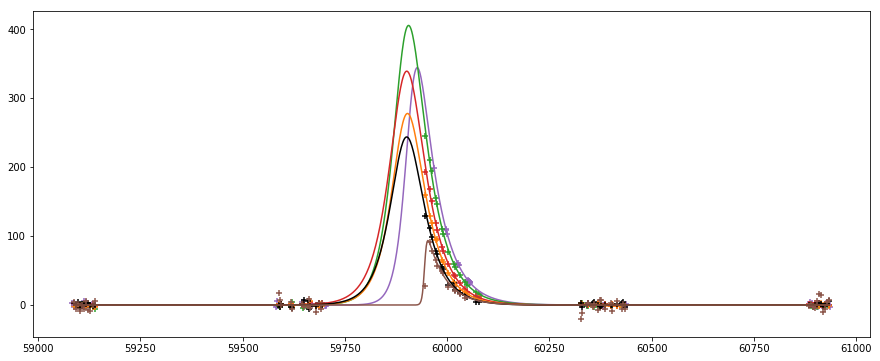

[59897.339599999796, 59897.331999999995, 59897.34719999999, 59897.358199999995]
t00 59897.343399999896
886.22 48.02 median cov: -0
790.17 46.29 median cov: -0
660.70 44.10 median cov: -0
547.24 43.15 median cov: -0
481.76 41.54 median cov: -0
351.67 44.87 median cov: -1


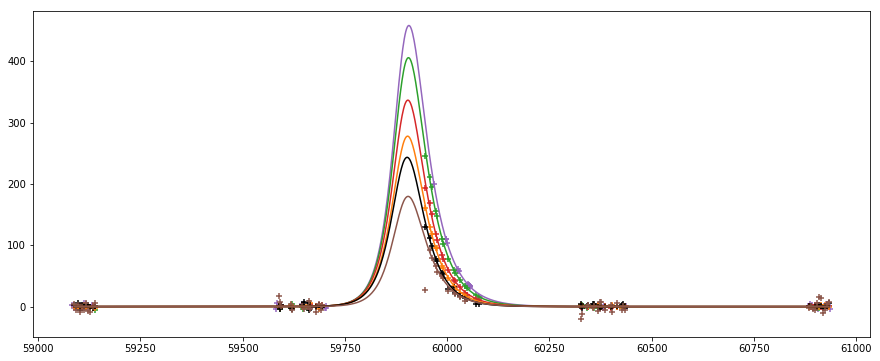

class 15 object_id =  23116
59939.0808 30 46.084736 1.0054000000018277
gap after
[161.296576, 59934.0808, 20, 40]
[92.169472, 59834.0808, 2.0, 4.0]
[230.42368, 59934.0808, 200, 400]
result: 92.17 59927.66 5.90 15.51 median cov: 0
59945.0846 31 61.381195 2.9956999999994878
gap after
[214.8341825, 59940.0846, 20, 40]
[122.76239, 59840.0846, 2.0, 4.0]
[306.905975, 59940.0846, 200, 400]
result: 122.76 59940.08 8.55 23.68 median cov: 0
59945.077 31 53.841301 3.0023999999975786
gap after
[188.44455349999998, 59940.077, 20, 40]
[107.682602, 59840.077, 2.0, 4.0]
[269.206505, 59940.077, 200, 400]
result: 107.68 59940.08 8.84 24.04 median cov: 0
59945.0922 31 49.198547 2.9956999999994878
gap after
[172.19491449999998, 59940.0922, 20, 40]
[98.397094, 59840.0922, 2.0, 4.0]
[245.99273499999998, 59940.0922, 200, 400]
result: 98.40 59940.09 7.40 17.83 median cov: 0
59945.1032 31 43.066681 2.9957999999969616
gap after
[150.7333835, 59940.1032, 20, 40]
[86.133362, 59840.1032, 2.0, 4.0]
[215.33340500000

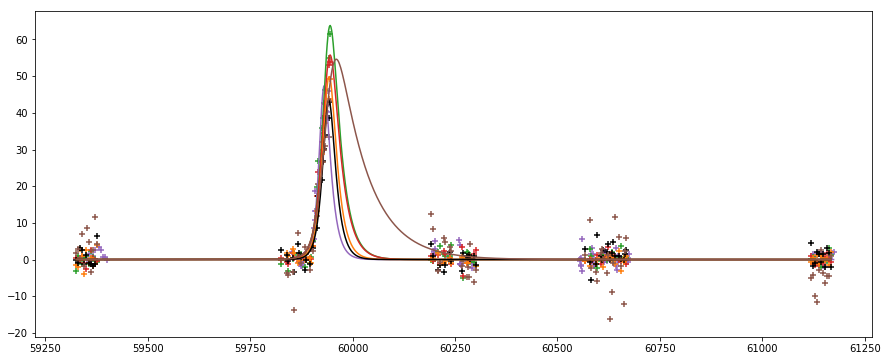

[59940.084599999995, 59940.07699999999, 59940.09219999999, 59940.10319999999]
t00 59940.08839999999
92.17 18.10 median cov: 0
122.76 20.29 median cov: 0
107.68 19.28 median cov: 0
98.40 20.83 median cov: 0
86.13 20.96 median cov: 0
86.50 19.00 median cov: 0


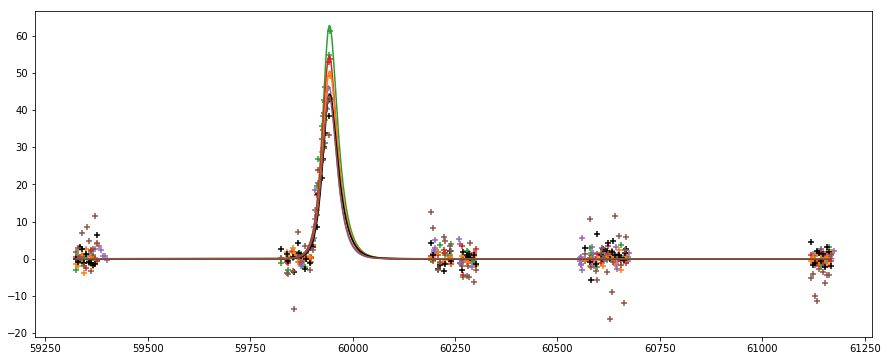

class 15 object_id =  97406
59819.1532 11 31.868305 100.0
gap before
[111.53906749999999, 59769.1532, 20, 40]
[63.73661, 59669.1532, 2.0, 4.0]
[159.341525, 59769.1532, 200, 400]
result: 128.40 59759.03 20.00 43.90 median cov: 68
59750.4306 11 121.80761000000001 100.0
gap before
[426.32663500000007, 59700.4306, 20, 40]
[243.61522000000002, 59600.4306, 2.0, 4.0]
[609.0380500000001, 59700.4306, 200, 400]
result: 458.22 59696.48 2.39 39.41 median cov: 0
59750.4229 11 82.106247 100.0
gap before
[287.3718645, 59700.4229, 20, 40]
[164.212494, 59600.4229, 2.0, 4.0]
[410.531235, 59700.4229, 200, 400]
result: 350.73 59696.47 2.05 36.93 median cov: 0
59752.4224 12 59.68713399999999 1.9841000000014901
[158.17090509999997, 59747.4224, 5, 10]
[77.5932742, 59647.4224, 0.5, 1.0]
[238.74853599999997, 59747.4224, 50, 100]
result: 192.29 59706.32 0.74 37.85 median cov: 0
59750.445 11 51.492214000000004 100.0
gap before
[180.22274900000002, 59700.445, 20, 40]
[102.98442800000001, 59600.445, 2.0, 4.0]
[257

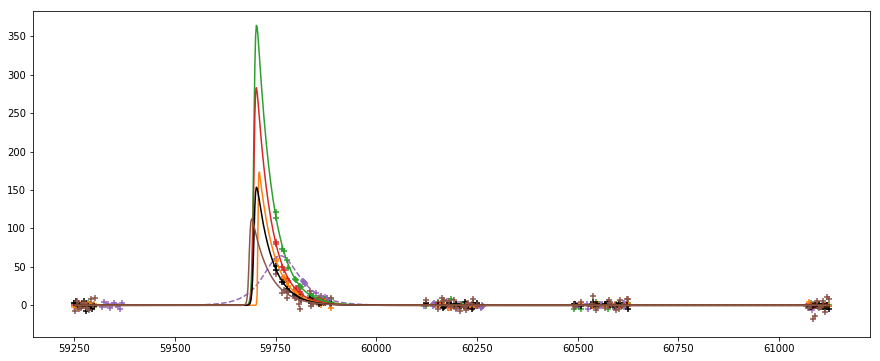

[59696.48410483393, 59696.46639644931, 59706.31773371744, 59696.749741836604]
t00 59696.61692333527
159.34 67.42 median cov: -2
456.68 39.41 median cov: -0
349.46 36.92 median cov: -0
238.75 38.65 median cov: -0
192.20 38.51 median cov: -1
102.58 42.69 median cov: -5


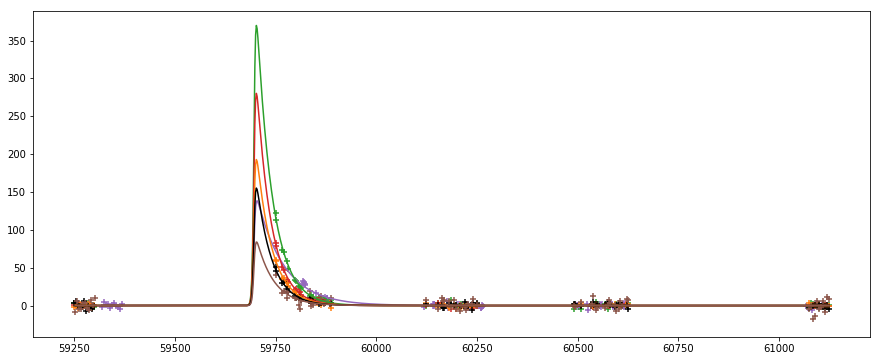

class 15 object_id =  113669
59851.1114 16 155.005539 27.96089999999822
[410.76467835, 59846.1114, 5, 10]
[201.5072007, 59746.1114, 0.5, 1.0]
[620.022156, 59846.1114, 50, 100]
result: 232.08 59846.11 4.97 64.20 median cov: 0
59857.0531 26 139.615845 2.9657999999981257
[369.98198925, 59852.0531, 5, 10]
[181.50059850000002, 59752.0531, 0.5, 1.0]
[558.46338, 59852.0531, 50, 100]
result: 199.08 59840.62 7.18 73.61 median cov: 0
59864.0162 27 108.175873 6.970900000000256
[286.66606345, 59859.0162, 5, 10]
[140.6286349, 59759.0162, 0.5, 1.0]
[432.703492, 59859.0162, 50, 100]
result: 154.31 59841.29 7.56 72.33 median cov: 0
59870.0349 29 83.81414000000001 3.00170000000071
[222.10747100000003, 59865.0349, 5, 10]
[108.95838200000001, 59765.0349, 0.5, 1.0]
[335.25656000000004, 59865.0349, 50, 100]
result: 119.10 59841.85 7.84 77.63 median cov: 0
59867.0443 28 71.26750899999999 3.0014999999984866
[188.85889884999997, 59862.0443, 5, 10]
[92.64776169999999, 59762.0443, 0.5, 1.0]
[285.07003599999996,

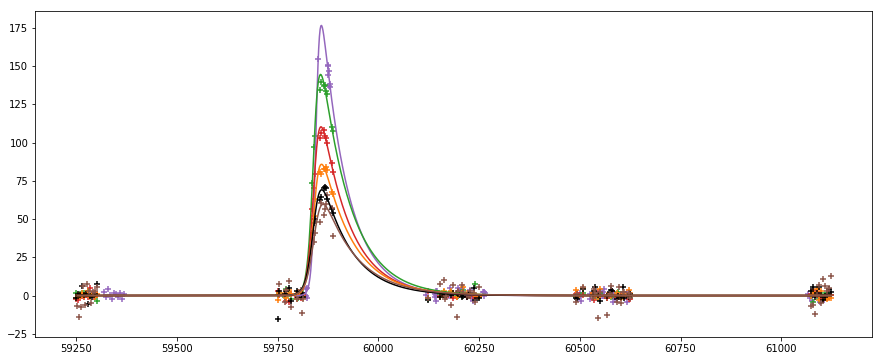

[59840.61933196623, 59841.291948287355, 59841.84762440842, 59841.59238335744]
t00 59841.4421658224
220.93 81.95 median cov: -0
204.35 69.46 median cov: 0
155.08 71.62 median cov: -0
117.75 79.94 median cov: -0
98.54 74.10 median cov: -0
85.19 80.19 median cov: -0


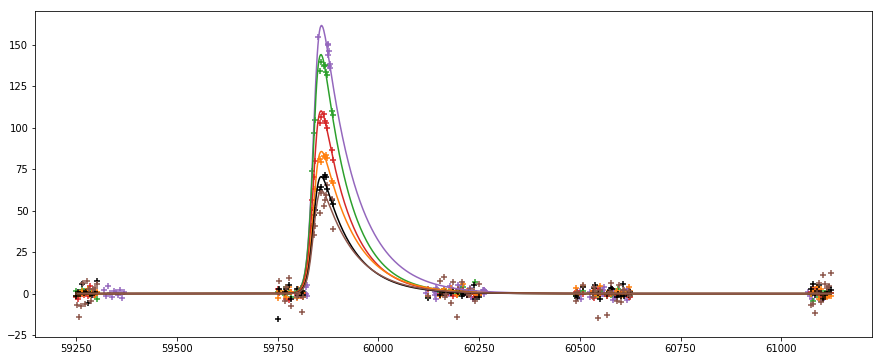

class 15 object_id =  133234
59968.1942 21 4.874873 264.12749999999505
gap before
[17.0620555, 59918.1942, 20, 40]
[9.749746, 59818.1942, 2.0, 4.0]
[24.374365, 59918.1942, 200, 400]
result: 15.05 59918.19 21.89 51.90 median cov: 134
59947.3396 25 10.523506 253.33920000000217
gap before
[36.832271, 59897.3396, 20, 40]
[21.047012, 59797.3396, 2.0, 4.0]
[52.617529999999995, 59897.3396, 200, 400]
result: 52.62 59897.34 2.01 31.03 median cov: 0
59947.332 25 8.756289 253.33929999999964
gap before
[30.647011500000005, 59897.332, 20, 40]
[17.512578, 59797.332, 2.0, 4.0]
[43.781445000000005, 59897.332, 200, 400]
result: 43.78 59894.28 17.96 31.80 median cov: 1
59947.3472 25 6.45411 253.3391999999949
gap before
[22.589385, 59897.3472, 20, 40]
[12.90822, 59797.3472, 2.0, 4.0]
[32.27055, 59897.3472, 200, 400]
result: 32.27 59897.35 17.61 26.96 median cov: 9
59947.3582 25 7.918692999999999 253.33929999999964
gap before
[27.715425499999995, 59897.3582, 20, 40]
[15.837385999999999, 59797.3582, 2.0, 4

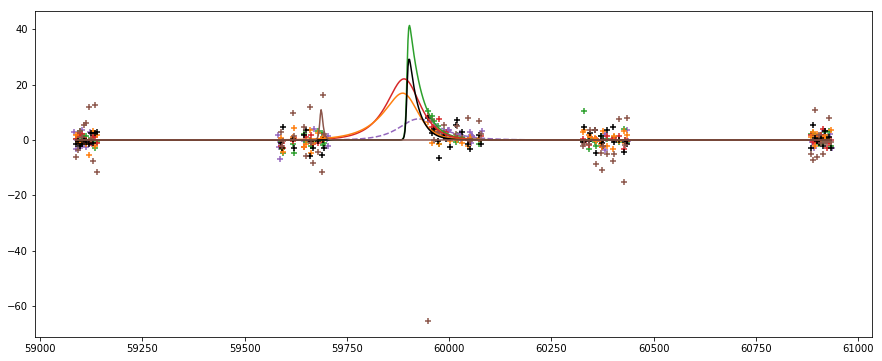

[59897.33959727593, 59894.2764703562, 59897.3471999182, 59897.35815300242]
t00 59897.34339859706
19.18 55.16 median cov: -2
52.62 31.06 median cov: -2
37.89 32.18 median cov: -2
32.27 26.69 median cov: -12
39.59 22.82 median cov: -61
20.92 4.46 median cov: 0


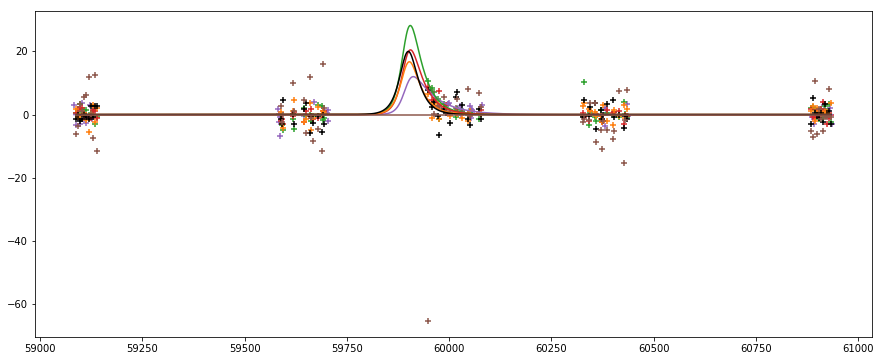

class 42
class 42 object_id =  730
59822.2433 15 5.942166 0.9955000000045402
[15.746739900000001, 59817.2433, 5, 10]
[7.724815800000001, 59717.2433, 0.5, 1.0]
[23.768664, 59817.2433, 50, 100]
result: 13.33 59807.75 11.98 9.10 median cov: 0
59857.1485 16 5.693109 2.9922000000005937
[15.08673885, 59852.1485, 5, 10]
[7.4010416999999995, 59752.1485, 0.5, 1.0]
[22.772436, 59852.1485, 50, 100]
result: 7.40 59845.58 0.50 5.23 median cov: 4000846
60532.3019 47 20.994711 245.19719999999506
gap before
[73.4814885, 60482.3019, 20, 40]
[41.989422, 60382.3019, 2.0, 4.0]
[104.97355499999999, 60482.3019, 200, 400]
result: 69.01 60482.30 18.90 47.28 median cov: 1
60538.298 49 33.572102 3.0023000000001048
[88.9660703, 60533.298, 5, 10]
[43.6437326, 60433.298, 0.5, 1.0]
[134.288408, 60533.298, 50, 100]
result: 63.03 60533.28 10.57 28.59 median cov: 1
60532.3282 46 41.159981 245.1973000000071
gap before
[144.0599335, 60482.3282, 20, 40]
[82.319962, 60382.3282, 2.0, 4.0]
[205.79990500000002, 60482.3282, 2

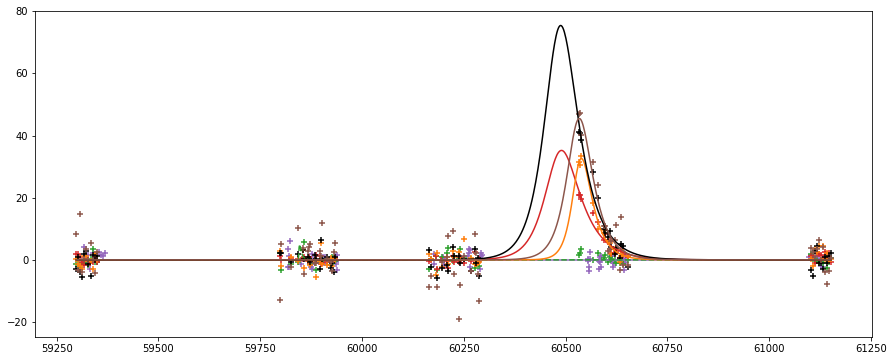

[60482.30189967495, 60533.28166150579, 60482.32819995279]
t00 60482.32819995279
13.33 9.10 median cov: 0
7.40 5.23 median cov: 0
64.60 48.37 median cov: -0
119.09 40.80 median cov: -0
140.60 44.25 median cov: -0
158.10 43.48 median cov: -1


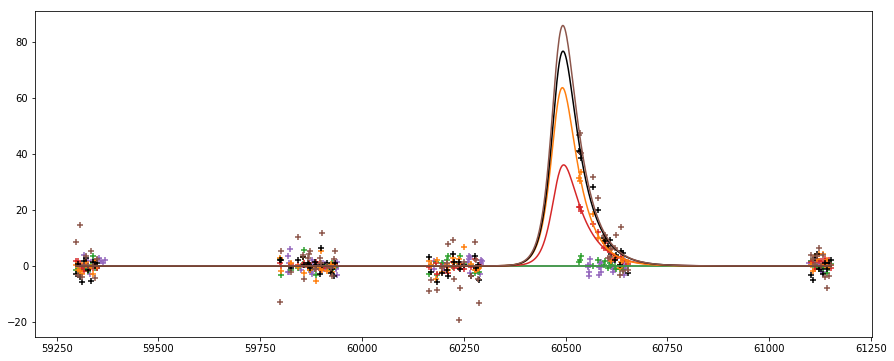

class 42 object_id =  1632
60199.0914 34 5.241472 0.983699999997043
[13.8899008, 60194.0914, 5, 10]
[6.8139136, 60094.0914, 0.5, 1.0]
[20.965888, 60194.0914, 50, 100]
result: 20.97 60194.09 1.25 1.70 median cov: 2
59770.2256 14 5.108418 2.9210999999995693
[13.537307700000001, 59765.2256, 5, 10]
[6.6409434, 59665.2256, 0.5, 1.0]
[20.433672, 59765.2256, 50, 100]
result: 16.45 59747.75 0.53 1.78 median cov: 9015025681
59779.3188 15 4.109369 9.100899999997637
[10.88982785, 59774.3188, 5, 10]
[5.3421797, 59674.3188, 0.5, 1.0]
[16.437476, 59774.3188, 50, 100]
result: 5.34 59771.23 1.43 10.95 median cov: 0
59750.4383 11 7.900053 100.0
gap before
[27.6501855, 59700.4383, 20, 40]
[15.800106, 59600.4383, 2.0, 4.0]
[39.500265, 59700.4383, 200, 400]
result: 26.11 59663.72 2.54 58.18 median cov: 0
59750.445 11 17.082548000000003 100.0
gap before
[59.78891800000001, 59700.445, 20, 40]
[34.165096000000005, 59600.445, 2.0, 4.0]
[85.41274000000001, 59700.445, 200, 400]
result: 34.17 59608.42 4.80 132.7

/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


result: 69.12 59602.45 2.50 136.44 median cov: 0


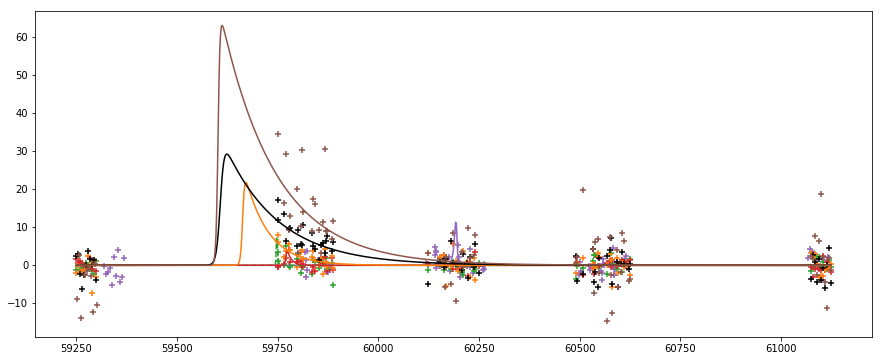

[59771.23211643183, 59663.720750385975, 59608.416725004594]
t00 59663.720750385975
20.97 1.70 median cov: 0
16.45 1.78 median cov: 0
5.34 2.00 median cov: 2
26.11 58.18 median cov: -0
34.17 95.97 median cov: -1
69.12 96.29 median cov: -0


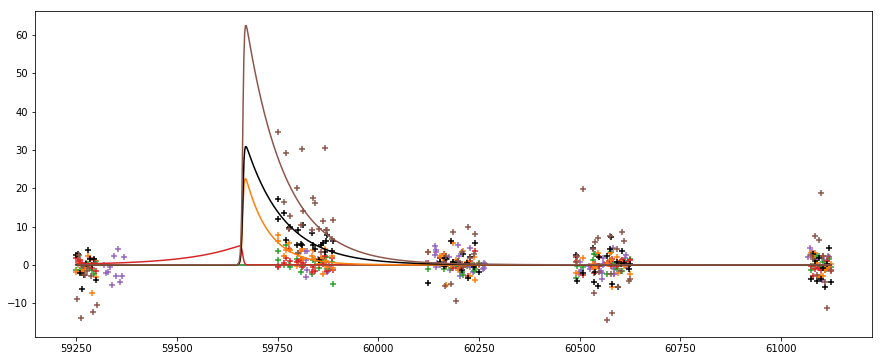

class 42 object_id =  2103
60228.0187 40 98.29547099999999 20.871800000000803
[260.48299814999996, 60223.0187, 5, 10]
[127.78411229999999, 60123.0187, 0.5, 1.0]
[393.18188399999997, 60223.0187, 50, 100]
result: 164.45 60223.02 2.64 12.98 median cov: 0
60224.0217 45 214.805969 2.998699999996461
[569.23581785, 60219.0217, 5, 10]
[279.2477597, 60119.0217, 0.5, 1.0]
[859.223876, 60219.0217, 50, 100]
result: 297.30 60219.02 2.00 17.75 median cov: 0
60224.014 45 134.434021 2.998700000003737
[356.25015565, 60219.014, 5, 10]
[174.76422730000002, 60119.014, 0.5, 1.0]
[537.736084, 60219.014, 50, 100]
result: 174.76 60219.01 2.71 49.09 median cov: 0
60224.0294 45 127.249214 2.998599999998987
[337.2104171, 60219.0294, 5, 10]
[165.4239782, 60119.0294, 0.5, 1.0]
[508.996856, 60219.0294, 50, 100]
result: 165.42 60219.03 2.90 57.97 median cov: 0
60227.0416 46 138.748123 3.0010999999940395
[367.68252595, 60222.0416, 5, 10]
[180.3725599, 60122.0416, 0.5, 1.0]
[554.992492, 60222.0416, 50, 100]
result: 18

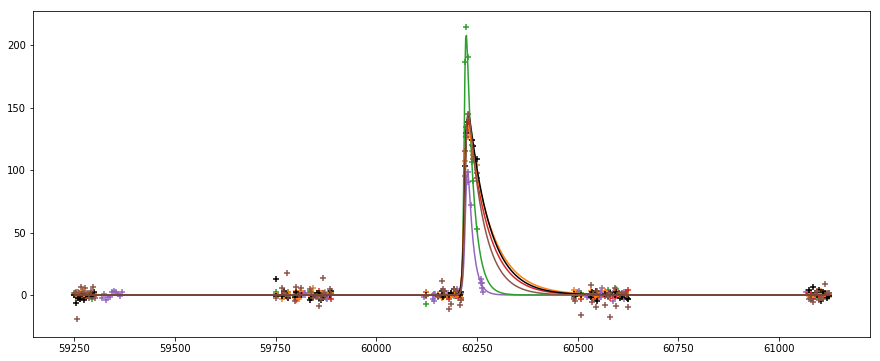

[60219.02169999999, 60219.013999999996, 60219.02939999999, 60220.14665814657]
t00 60219.02554999999
193.55 14.10 median cov: -0
318.66 16.90 median cov: -0
174.76 49.08 median cov: 0
165.42 57.42 median cov: 0
180.37 51.94 median cov: 0
188.54 40.39 median cov: -0


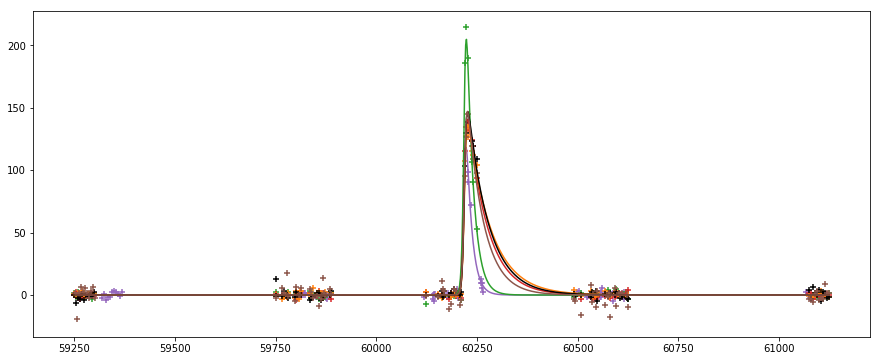

class 42 object_id =  2300
59363.2219 9 6.641854387785423 100.0
gap before
gap after
[23.24649035724898, 59313.2219, 20, 40]
[13.283708775570846, 59213.2219, 2.0, 4.0]
[33.20927193892712, 59313.2219, 200, 400]
result: 20.74 59301.43 57.04 36.71 median cov: 0
60596.095 61 4.307523000000001 3.0714000000007218
[11.414935950000002, 60591.095, 5, 10]
[5.5997799000000015, 60491.095, 0.5, 1.0]
[17.230092000000003, 60591.095, 50, 100]
result: 5.83 60583.96 0.53 1.86 median cov: 25149
59770.3662 11 3.291617 100.0
gap before
[11.5206595, 59720.3662, 20, 40]
[6.583234, 59620.3662, 2.0, 4.0]
[16.458085, 59720.3662, 200, 400]
result: 11.13 59715.32 3.14 45.08 median cov: 12269047
59770.3817 11 18.823622 100.0
gap before
[65.882677, 59720.3817, 20, 40]
[37.647244, 59620.3817, 2.0, 4.0]
[94.11811, 59720.3817, 200, 400]
result: 62.67 59620.38 42.18 118.33 median cov: 1
59782.2639 13 20.846098 2.8378000000011525
[55.2421597, 59777.2639, 5, 10]
[27.099927400000002, 59677.2639, 0.5, 1.0]
[83.384392, 5977

/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in multiply


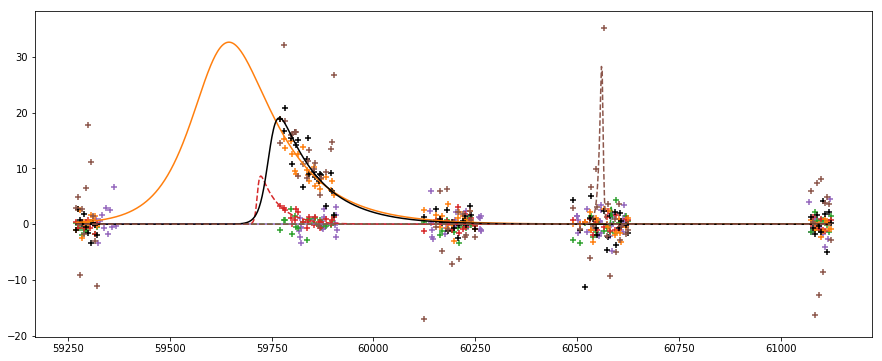

[59620.381700000034, 59745.95600109638]
t00 59683.16885054821
33.21 7.77 median cov: 38
5.83 1.86 median cov: 0
16.46 51.86 median cov: -0
37.65 115.35 median cov: -0
49.31 100.00 median cov: -0
51.40 2.11 median cov: 0


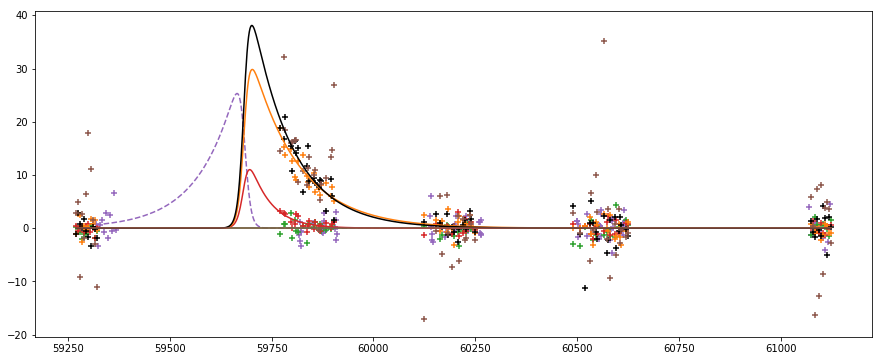

class 42 object_id =  3285
60435.9857 39 27.857284999999997 52.860799999994924
gap before
[97.5004975, 60385.9857, 20, 40]
[55.714569999999995, 60285.9857, 2.0, 4.0]
[139.28642499999998, 60385.9857, 200, 400]
result: 55.71 60385.99 2.00 61.75 median cov: 1
60403.0258 51 154.806046 3.0089000000007218
[410.2360219, 60398.0258, 5, 10]
[201.24785980000001, 60298.0258, 0.5, 1.0]
[619.224184, 60398.0258, 50, 100]
result: 201.25 60398.03 3.49 27.06 median cov: 0
60414.9975 52 122.826347 11.979299999999057
[325.48981955, 60409.9975, 5, 10]
[159.6742511, 60309.9975, 0.5, 1.0]
[491.305388, 60409.9975, 50, 100]
result: 170.33 60402.13 1.93 39.75 median cov: 0
60415.0127 52 106.12089499999999 11.979299999999057
[281.22037174999997, 60410.0127, 5, 10]
[137.95716349999998, 60310.0127, 0.5, 1.0]
[424.48357999999996, 60410.0127, 50, 100]
result: 137.96 60402.02 1.73 62.49 median cov: 0
60415.0237 52 114.254494 11.979299999999057
[302.77440909999996, 60410.0237, 5, 10]
[148.5308422, 60310.0237, 0.5, 1.

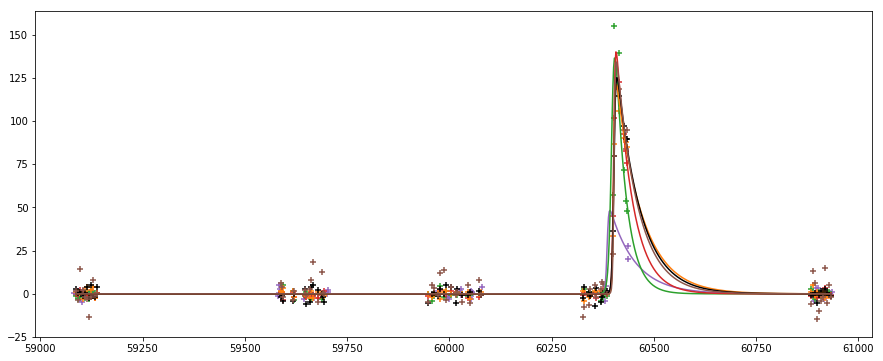

[60398.025799999996, 60402.13410149789, 60402.021914664685, 60402.67139776094]
t00 60402.078008081284
139.29 19.72 median cov: -229
254.34 19.33 median cov: -0
169.19 40.25 median cov: -0
137.96 62.42 median cov: -0
148.53 58.32 median cov: 0
154.41 54.05 median cov: -0


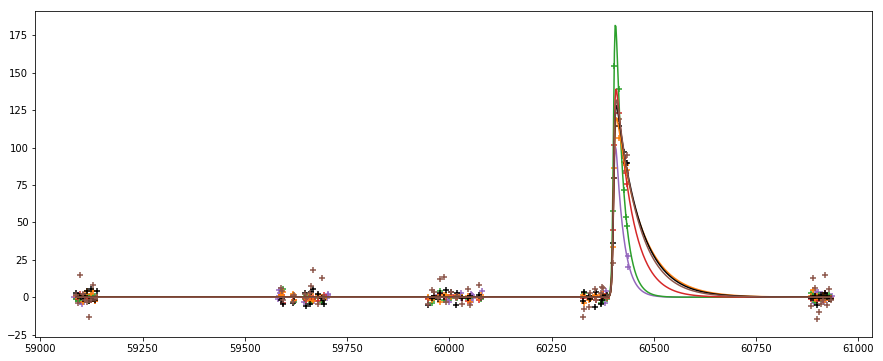

class 52
class 52 object_id =  10757
59908.0487 23 89.204865 1.0006999999968684
[236.39289225, 59903.0487, 5, 10]
[115.9663245, 59803.0487, 0.5, 1.0]
[356.81946, 59903.0487, 50, 100]
result: 135.68 59903.05 2.87 9.46 median cov: 0
59913.2522 24 228.502823 11.200000000004366
[605.53248095, 59908.2522, 5, 10]
[297.05366990000005, 59808.2522, 0.5, 1.0]
[914.011292, 59908.2522, 50, 100]
result: 483.70 59907.98 3.94 10.94 median cov: 0
59916.0544 25 260.09411600000004 2.809800000002724
[689.2494074000001, 59911.0544, 5, 10]
[338.12235080000005, 59811.0544, 0.5, 1.0]
[1040.3764640000002, 59911.0544, 50, 100]
result: 495.07 59911.05 5.07 19.21 median cov: 0
59916.0697 25 243.139786 2.809800000002724
[644.3204329, 59911.0697, 5, 10]
[316.08172179999997, 59811.0697, 0.5, 1.0]
[972.559144, 59911.0697, 50, 100]
result: 442.14 59911.06 5.53 23.14 median cov: 0
59924.0851 26 246.957092 8.00449999999546
[654.4362937999999, 59919.0851, 5, 10]
[321.0442196, 59819.0851, 0.5, 1.0]
[987.828368, 59919.085

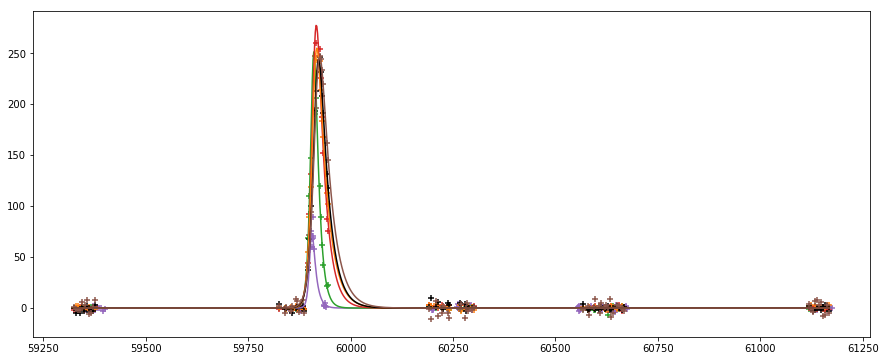

[59907.98479418502, 59911.05439999999, 59911.06311905186, 59915.80583706127]
t00 59911.05875952593
130.53 9.41 median cov: 0
389.90 11.29 median cov: -0
485.94 19.71 median cov: -0
445.65 22.77 median cov: -0
380.06 31.49 median cov: -0
349.49 43.94 median cov: -0


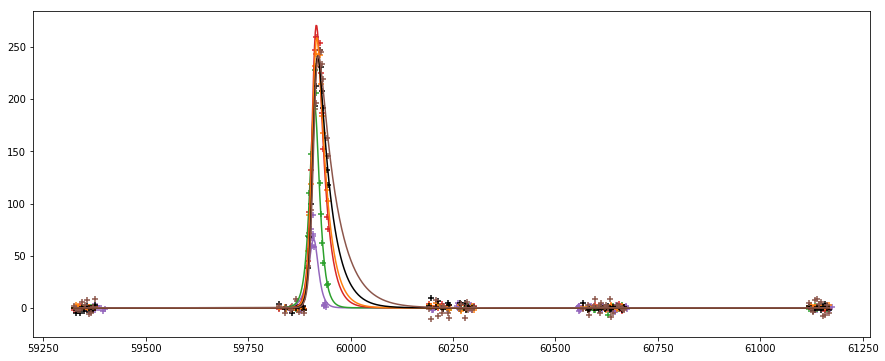

class 52 object_id =  11773
59585.2363 14 3.817046 0.9930999999996857
[10.1151719, 59580.2363, 5, 10]
[4.9621598, 59480.2363, 0.5, 1.0]
[15.268184, 59580.2363, 50, 100]
result: 9.68 59570.02 9.18 9.10 median cov: 0
59962.2019 27 4.680262 4.90570000000298
[12.4026943, 59957.2019, 5, 10]
[6.0843406, 59857.2019, 0.5, 1.0]
[18.721048, 59957.2019, 50, 100]
result: 6.10 59912.64 0.79 88.28 median cov: 0
59947.332 25 24.026203 253.33929999999964
gap before
[84.09171049999999, 59897.332, 20, 40]
[48.052406, 59797.332, 2.0, 4.0]
[120.13101499999999, 59897.332, 200, 400]
result: 65.66 59872.66 2.28 72.31 median cov: 0
59947.3472 25 42.182190000000006 253.3391999999949
gap before
[147.63766500000003, 59897.3472, 20, 40]
[84.36438000000001, 59797.3472, 2.0, 4.0]
[210.91095, 59897.3472, 200, 400]
result: 210.91 59851.11 19.12 57.44 median cov: 1
59947.3582 25 39.860256 253.33929999999964
gap before
[139.510896, 59897.3582, 20, 40]
[79.720512, 59797.3582, 2.0, 4.0]
[199.30128, 59897.3582, 200, 400]


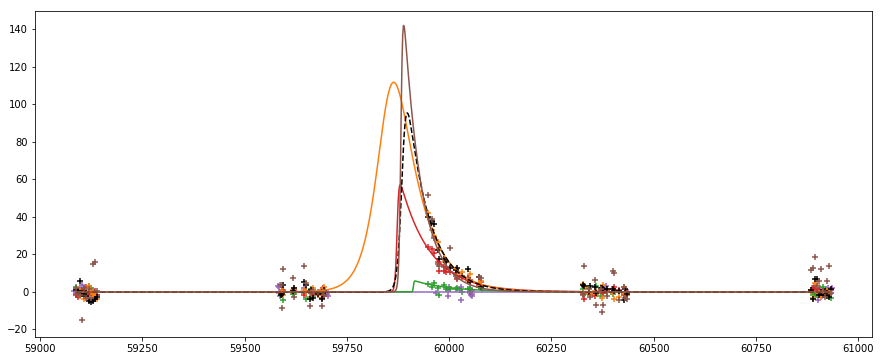

[59912.63824688365, 59872.66462142995, 59851.10957982282]
t00 59872.66462142995
4.98 1.03 median cov: 0
9.61 88.21 median cov: -1
65.66 72.31 median cov: -0
144.34 57.49 median cov: -0
168.62 53.70 median cov: -1
216.47 44.09 median cov: -9


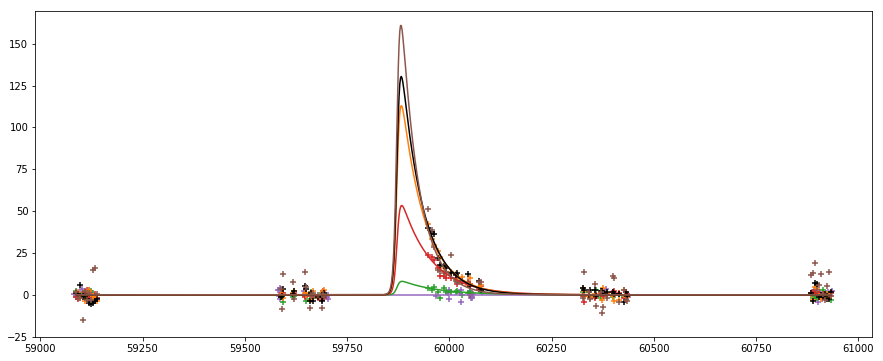

class 52 object_id =  13138
59822.1105 14 6.615659 1.007900000004156
[17.53149635, 59817.1105, 5, 10]
[8.6003567, 59717.1105, 0.5, 1.0]
[26.462636, 59817.1105, 50, 100]
result: 13.86 59761.52 2.35 57.10 median cov: 0
59750.4306 11 759.230164 100.0
gap before
[2657.305574, 59700.4306, 20, 40]
[1518.460328, 59600.4306, 2.0, 4.0]
[3796.15082, 59700.4306, 200, 400]
result: 3796.15 59700.43 2.00 24.86 median cov: 0
59752.407 12 861.5307619999999 1.9841000000014901
[2283.0565192999998, 59747.407, 5, 10]
[1119.9899905999998, 59647.407, 0.5, 1.0]
[3446.1230479999995, 59747.407, 50, 100]
result: 1325.35 59730.07 0.67 34.73 median cov: 0
59752.4224 12 741.2814940000001 1.9841000000014901
[1964.3959591000003, 59747.4224, 5, 10]
[963.6659422000001, 59647.4224, 0.5, 1.0]
[2965.1259760000003, 59747.4224, 50, 100]
result: 1894.39 59706.51 0.68 43.11 median cov: 0
59752.4334 12 665.079895 1.9884000000020023
[1762.46172175, 59747.4334, 5, 10]
[864.6038635, 59647.4334, 0.5, 1.0]
[2660.31958, 59747.4334,

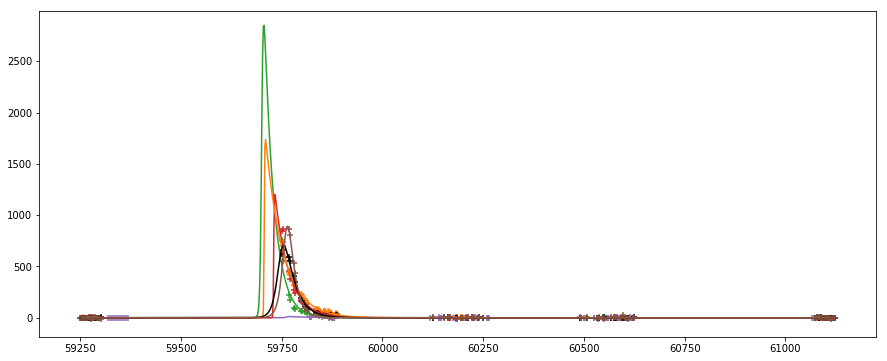

[59700.4305822453, 59730.069049172234, 59706.50999484721, 59747.433399999994]
t00 59718.28952200973
26.46 60.10 median cov: -0
3796.15 18.39 median cov: -0
1860.43 34.73 median cov: -0
1441.50 43.11 median cov: -0
2131.36 33.42 median cov: -0
3062.54 30.86 median cov: -1


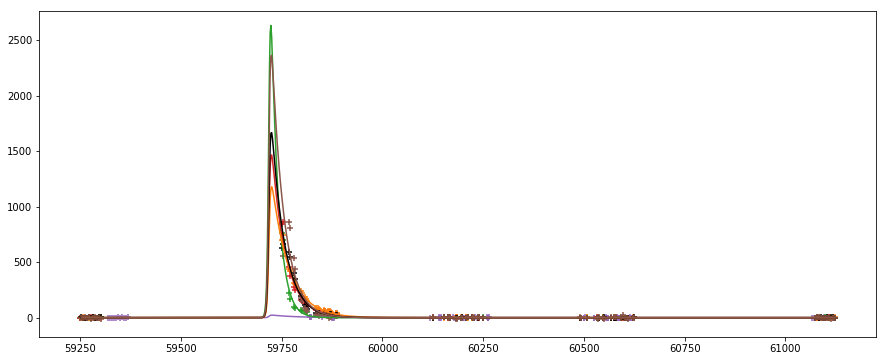

class 52 object_id =  14279
60559.249 54 5.099809 0.995600000002014
[13.51449385, 60554.249, 5, 10]
[6.6297517, 60454.249, 0.5, 1.0]
[20.399236, 60554.249, 50, 100]
result: 10.95 60547.97 12.10 10.06 median cov: 0
59825.2676 11 65.512527 100.0
gap before
[229.2938445, 59775.2676, 20, 40]
[131.025054, 59675.2676, 2.0, 4.0]
[327.562635, 59775.2676, 200, 400]
result: 327.56 59775.27 2.52 27.32 median cov: 70573
59839.2161 12 99.276337 13.956099999995786
[263.08229305, 59834.2161, 5, 10]
[129.05923810000002, 59734.2161, 0.5, 1.0]
[397.105348, 59834.2161, 50, 100]
result: 196.25 59825.89 2.11 20.19 median cov: 0
59842.214 13 134.971375 2.9827000000004773
[357.67414375, 59837.214, 5, 10]
[175.4627875, 59737.214, 0.5, 1.0]
[539.8855, 59837.214, 50, 100]
result: 206.39 59826.03 2.00 30.78 median cov: 0
59839.2422 12 119.638626 13.955999999998312
[317.0423589, 59834.2422, 5, 10]
[155.5302138, 59734.2422, 0.5, 1.0]
[478.554504, 59834.2422, 50, 100]
result: 155.53 59825.33 0.50 38.11 median cov: 

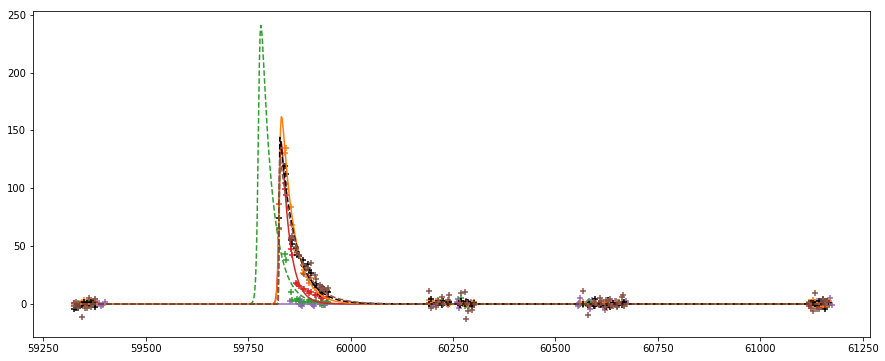

[59825.88597850864, 59826.02906017013]
t00 59825.95751933938
11.10 16.82 median cov: -1
147.53 11.33 median cov: -0
198.77 19.94 median cov: -0
205.27 30.97 median cov: -0
155.53 37.56 median cov: -0
135.62 42.25 median cov: -0


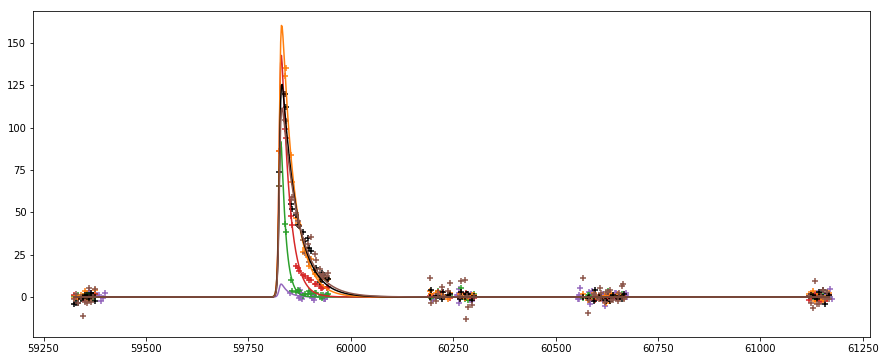

class 52 object_id =  15718
60261.0632 38 28.393259000000004 0.985899999999674
[75.24213635000001, 60256.0632, 5, 10]
[36.9112367, 60156.0632, 0.5, 1.0]
[113.57303600000002, 60256.0632, 50, 100]
result: 57.60 60256.06 2.55 7.95 median cov: 0
60267.0519 40 64.29409799999999 25.910100000000966
[170.37935969999998, 60262.0519, 5, 10]
[83.5823274, 60162.0519, 0.5, 1.0]
[257.17639199999996, 60262.0519, 50, 100]
result: 125.40 60262.05 2.77 9.98 median cov: 0
60267.0443 40 75.335854 25.910100000000966
[199.6400131, 60262.0443, 5, 10]
[97.9366102, 60162.0443, 0.5, 1.0]
[301.343416, 60262.0443, 50, 100]
result: 110.26 60262.04 2.40 19.14 median cov: 0
60267.0595 40 71.516266 25.910000000003492
[189.5181049, 60262.0595, 5, 10]
[92.9711458, 60162.0595, 0.5, 1.0]
[286.065064, 60262.0595, 50, 100]
result: 119.40 60253.68 0.63 24.80 median cov: 6804
60270.1344 41 61.661469 3.063900000001013
[163.40289285, 60265.1344, 5, 10]
[80.1599097, 60165.1344, 0.5, 1.0]
[246.645876, 60265.1344, 50, 100]
result

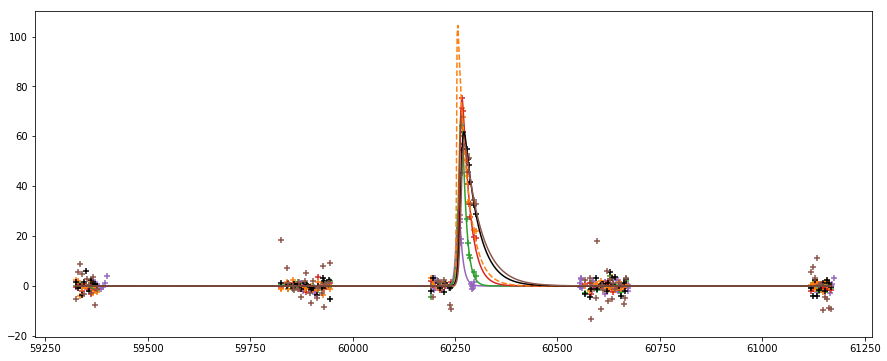

[60262.05189999994, 60262.044299999994, 60264.42067445777]
t00 60262.05189999994
50.57 4.25 median cov: 0
123.81 10.05 median cov: -0
113.07 18.73 median cov: -0
96.88 21.81 median cov: -0
80.16 39.88 median cov: 0
73.97 44.73 median cov: -0


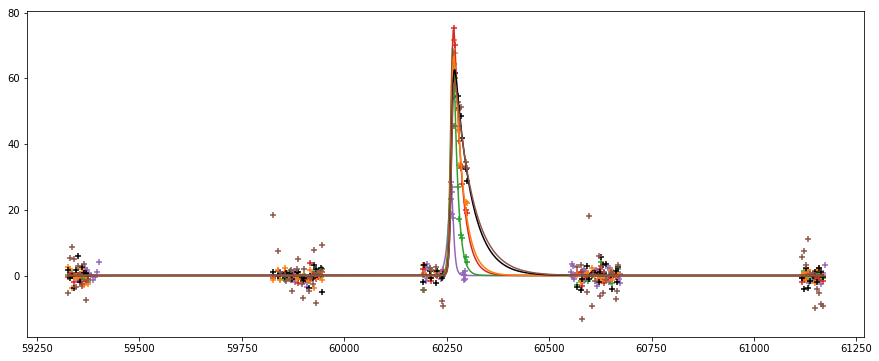

class 62
class 62 object_id =  3910
60502.2441 59 4.828198 0.9892000000036205
[12.794724700000002, 60497.2441, 5, 10]
[6.2766574, 60397.2441, 0.5, 1.0]
[19.312792, 60497.2441, 50, 100]
result: 11.27 60490.35 10.06 9.03 median cov: 0
60546.1263 54 28.802496 7.953600000000733
[76.32661440000001, 60541.1263, 5, 10]
[37.4432448, 60441.1263, 0.5, 1.0]
[115.209984, 60541.1263, 50, 100]
result: 70.99 60541.13 0.78 5.61 median cov: 0
60546.1186 54 67.834053 7.953600000000733
[179.76024045, 60541.1186, 5, 10]
[88.1842689, 60441.1186, 0.5, 1.0]
[271.336212, 60541.1186, 50, 100]
result: 143.98 60541.12 0.66 6.91 median cov: 0
60546.1341 54 100.696465 7.953700000005483
[266.84563225, 60541.1341, 5, 10]
[130.9054045, 60441.1341, 0.5, 1.0]
[402.78586, 60541.1341, 50, 100]
result: 199.04 60541.13 0.50 8.20 median cov: 0
60546.1452 54 125.06008100000001 7.953699999998207
[331.40921465, 60541.1452, 5, 10]
[162.57810530000003, 60441.1452, 0.5, 1.0]
[500.24032400000004, 60541.1452, 50, 100]
result: 212.1

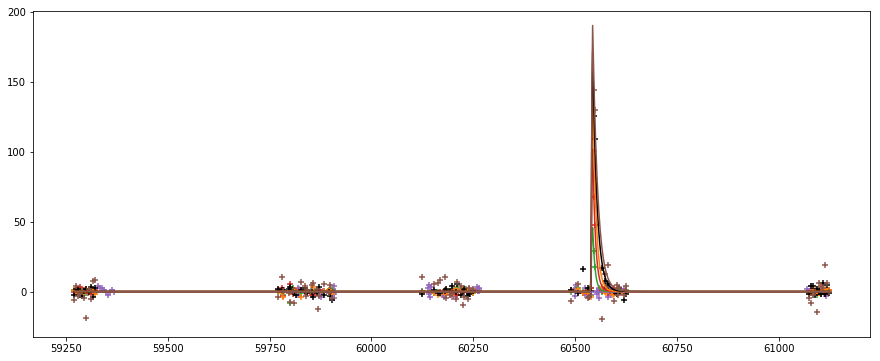

[60541.126299999996, 60541.118599999994, 60541.134099999996, 60541.14519999999]
t00 60541.1302
6.64 1.73 median cov: -370550
71.18 5.59 median cov: -0
143.85 6.90 median cov: -0
198.55 8.23 median cov: -0
212.37 10.79 median cov: -0
228.86 12.53 median cov: -0


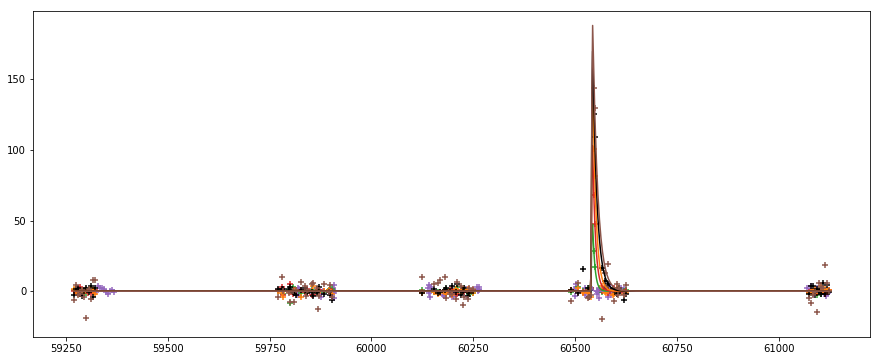

class 62 object_id =  7703
60201.2281 34 6.864739999999999 0.9967000000033295
[18.191561, 60196.2281, 5, 10]
[8.924161999999999, 60096.2281, 0.5, 1.0]
[27.458959999999998, 60196.2281, 50, 100]
result: 16.73 60189.71 10.08 9.61 median cov: 0
60192.3006 32 39.355915 247.21600000000035
gap before
[137.74570250000002, 60142.3006, 20, 40]
[78.71183, 60042.3006, 2.0, 4.0]
[196.77957500000002, 60142.3006, 200, 400]
result: 196.78 60142.30 17.13 33.91 median cov: 0
60192.293 32 111.532478 247.21600000000035
gap before
[390.36367299999995, 60142.293, 20, 40]
[223.064956, 60042.293, 2.0, 4.0]
[557.66239, 60142.293, 200, 400]
result: 242.17 60142.29 21.18 69.45 median cov: 0
60192.3082 32 157.404678 247.21600000000035
gap before
[550.916373, 60142.3082, 20, 40]
[314.809356, 60042.3082, 2.0, 4.0]
[787.02339, 60142.3082, 200, 400]
result: 540.58 60142.31 2.02 40.02 median cov: 0
60192.3192 32 134.46138 247.21600000000035
gap before
[470.61483, 60142.3192, 20, 40]
[268.92276, 60042.3192, 2.0, 4.0]
[

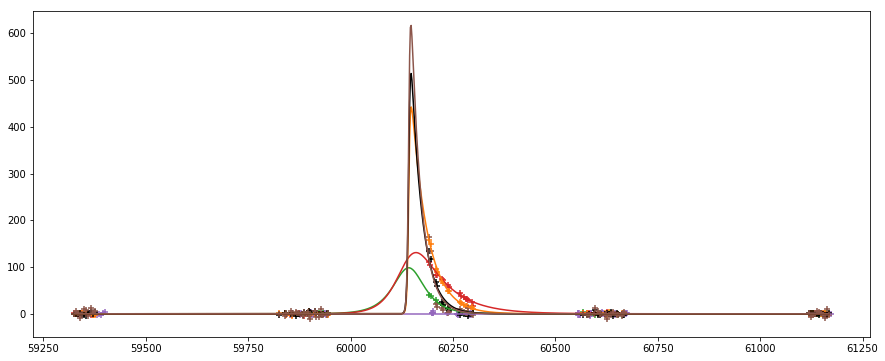

[60142.300599999995, 60142.29299999999, 60142.30818215407, 60142.31918348254]
t00 60142.304391077036
27.46 24.56 median cov: -4
196.78 33.54 median cov: -0
223.06 72.45 median cov: -0
540.87 40.01 median cov: -0
672.31 28.05 median cov: -0
817.80 25.23 median cov: -2


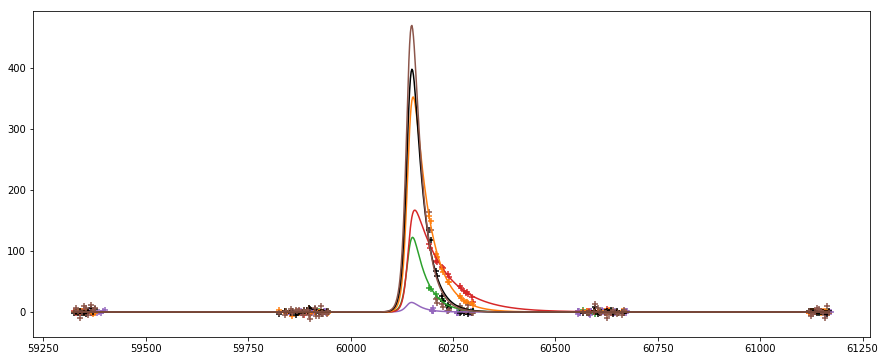

class 62 object_id =  11770
59822.1105 14 6.706411 1.007900000004156
[17.77198915, 59817.1105, 5, 10]
[8.7183343, 59717.1105, 0.5, 1.0]
[26.825644, 59817.1105, 50, 100]
result: 16.07 59807.22 11.08 9.32 median cov: 0
60237.2283 47 8.292313 10.205500000003667
[21.974629450000002, 60232.2283, 5, 10]
[10.7800069, 60132.2283, 0.5, 1.0]
[33.169252, 60232.2283, 50, 100]
result: 25.14 60232.23 0.50 4.58 median cov: 80
60237.2206 47 32.864902 10.205500000003667
[87.0919903, 60232.2206, 5, 10]
[42.7243726, 60132.2206, 0.5, 1.0]
[131.459608, 60232.2206, 50, 100]
result: 92.81 60232.22 0.50 4.82 median cov: 1
60237.2359 47 65.697731 10.205399999998917
[174.09898715000003, 60232.2359, 5, 10]
[85.40705030000001, 60132.2359, 0.5, 1.0]
[262.790924, 60232.2359, 50, 100]
result: 171.26 60232.24 0.50 5.24 median cov: 0
60237.2468 47 93.654999 10.20520000000397
[248.18574735, 60232.2468, 5, 10]
[121.75149870000001, 60132.2468, 0.5, 1.0]
[374.619996, 60232.2468, 50, 100]
result: 196.90 60232.25 0.89 7.04 

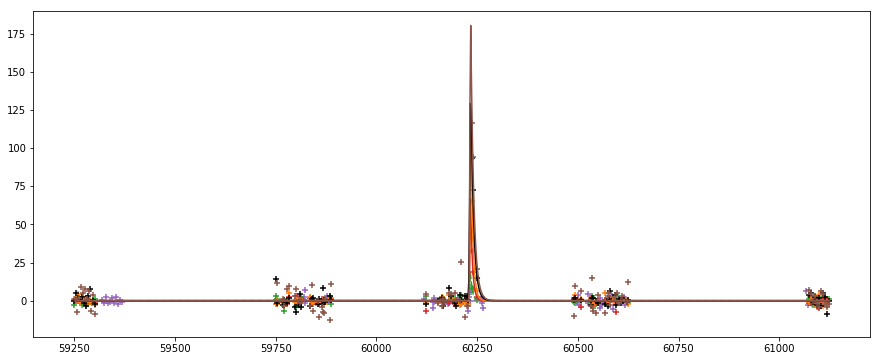

[60232.2205999996, 60232.23589999883, 60232.24679999999]
t00 60232.23589999883
18.05 1.59 median cov: -2
25.10 4.58 median cov: -0
92.52 4.82 median cov: -0
171.26 5.24 median cov: -0
196.30 7.06 median cov: -0
239.31 7.60 median cov: -0


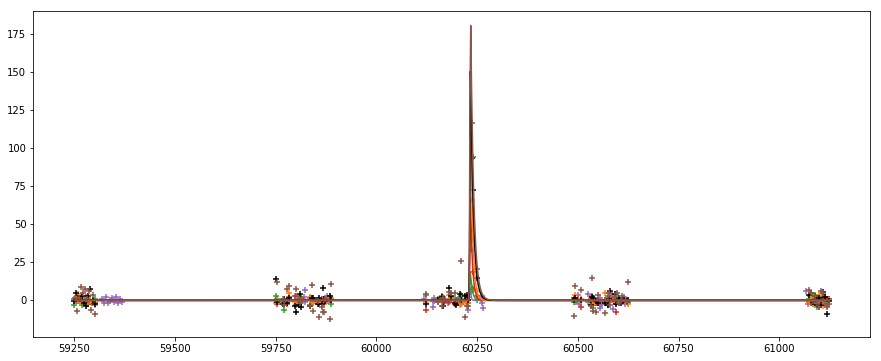

class 62 object_id =  17370
60500.2524 57 45.730022 0.9945000000006985
[121.18455829999999, 60495.2524, 5, 10]
[59.4490286, 60395.2524, 0.5, 1.0]
[182.920088, 60495.2524, 50, 100]
result: 80.28 60495.25 9.15 22.87 median cov: 0
60508.3203 49 86.508408 16.968000000000757
[229.2472812, 60503.3203, 5, 10]
[112.46093040000001, 60403.3203, 0.5, 1.0]
[346.033632, 60503.3203, 50, 100]
result: 164.07 60503.32 6.87 29.09 median cov: 0
60520.4204 50 138.62158200000002 12.107800000005227
[367.3471923000001, 60515.4204, 5, 10]
[180.20805660000002, 60415.4204, 0.5, 1.0]
[554.4863280000001, 60515.4204, 50, 100]
result: 258.05 60513.27 9.70 34.14 median cov: 0
60532.2696 51 176.939102 11.833899999997811
[468.88862029999996, 60527.2696, 5, 10]
[230.0208326, 60427.2696, 0.5, 1.0]
[707.756408, 60527.2696, 50, 100]
result: 316.06 60514.92 10.84 45.69 median cov: 0
60535.1995 52 202.505997 2.9187000000019907
[536.64089205, 60530.1995, 5, 10]
[263.2577961, 60430.1995, 0.5, 1.0]
[810.023988, 60530.1995, 50,

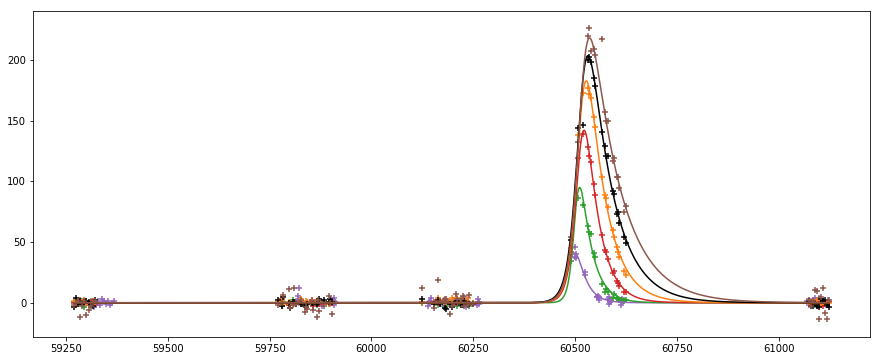

[60503.32029999999, 60513.27288196309, 60514.92337031953, 60515.571903311]
t00 60514.09812614131
72.60 14.10 median cov: 0
164.03 23.41 median cov: -0
259.26 33.72 median cov: -0
312.91 46.43 median cov: -0
328.41 60.72 median cov: -0
326.32 78.31 median cov: -0


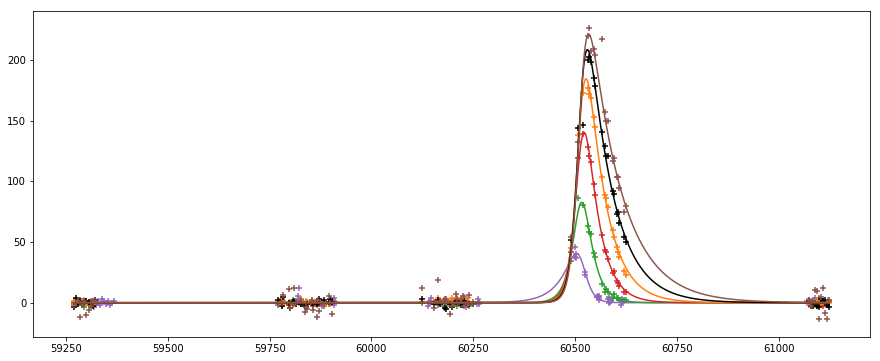

class 62 object_id =  18645
60141.2435 32 4.856072 1.0031999999991967
[12.8685908, 60136.2435, 5, 10]
[6.312893600000001, 60036.2435, 0.5, 1.0]
[19.424288, 60136.2435, 50, 100]
result: 12.07 60126.29 10.06 9.03 median cov: 0
60538.1727 53 5.462331 2.99210000000312
[14.47517715, 60533.1727, 5, 10]
[7.1010303, 60433.1727, 0.5, 1.0]
[21.849324, 60533.1727, 50, 100]
result: 7.20 60524.95 0.50 1.77 median cov: 284767690
60491.3446 48 7.095283 242.2632999999987
gap before
[24.833490500000003, 60441.3446, 20, 40]
[14.190566, 60341.3446, 2.0, 4.0]
[35.476415, 60441.3446, 200, 400]
result: 32.97 60441.34 13.35 35.17 median cov: 7
60491.36 48 14.542692 242.26340000000346
gap before
[50.899422, 60441.36, 20, 40]
[29.085384, 60341.36, 2.0, 4.0]
[72.71346, 60441.36, 200, 400]
result: 65.67 60441.36 15.52 36.24 median cov: 1
60520.4414 50 7.665682 12.102300000005926
[20.3140573, 60515.4414, 5, 10]
[9.9653866, 60415.4414, 0.5, 1.0]
[30.662728, 60515.4414, 50, 100]
result: 30.66 60515.44 0.50 4.31 med

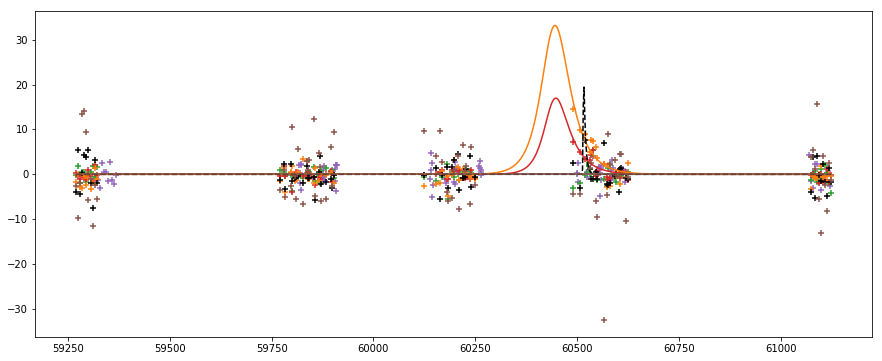

[60441.344599965705, 60441.35999999812]
t00 60441.35229998191
12.07 9.03 median cov: 0
7.20 1.77 median cov: 0
32.62 35.26 median cov: -1
63.69 36.55 median cov: -2
30.66 4.31 median cov: 0
31.32 14.39 median cov: 56


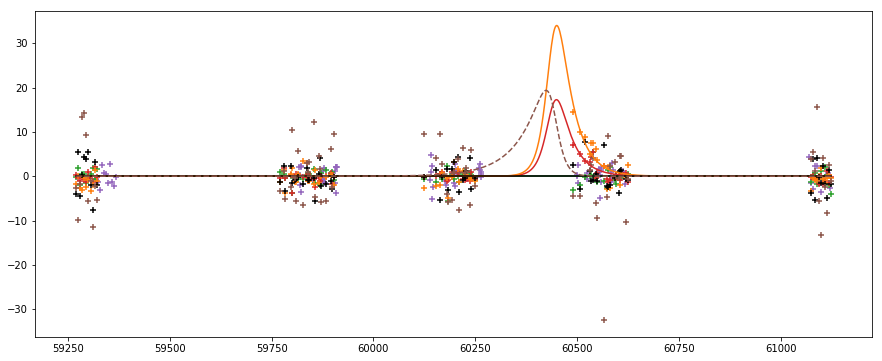

class 67
class 67 object_id =  2922
60118.4163 24 16.806917000000002 238.39049999999406
gap before
[58.82420950000001, 60068.4163, 20, 40]
[33.613834000000004, 59968.4163, 2.0, 4.0]
[84.034585, 60068.4163, 200, 400]
result: 84.03 60068.42 15.56 28.55 median cov: 0
60124.2618 33 56.288123999999996 237.22430000000168
gap before
[197.00843399999997, 60074.2618, 20, 40]
[112.57624799999999, 59974.2618, 2.0, 4.0]
[281.44061999999997, 60074.2618, 200, 400]
result: 233.80 60071.19 2.00 32.17 median cov: 0
60124.2541 33 294.855255 237.22430000000168
gap before
[1031.9933925, 60074.2541, 20, 40]
[589.71051, 59974.2541, 2.0, 4.0]
[1474.276275, 60074.2541, 200, 400]
result: 1474.26 60074.25 2.01 27.07 median cov: 0
60124.2695 33 491.29351799999995 237.22439999999915
gap before
[1719.5273129999998, 60074.2695, 20, 40]
[982.5870359999999, 59974.2695, 2.0, 4.0]
[2456.4675899999997, 60074.2695, 200, 400]
result: 2456.46 60074.27 2.00 25.93 median cov: 0
60124.2807 33 477.137726 237.2245000000039
gap 

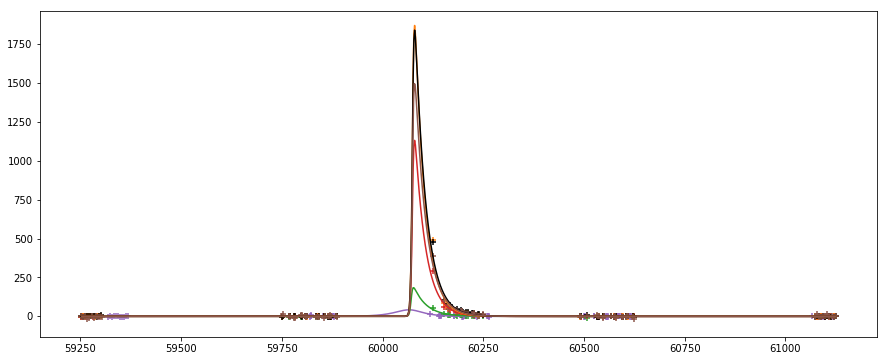

[60071.18657519899, 60074.25409748515, 60074.26949727415, 60074.28069311114]
t00 60074.26179737965
84.03 25.63 median cov: -0
213.45 32.12 median cov: -0
1474.28 27.07 median cov: -0
2456.47 25.93 median cov: -0
2385.69 27.77 median cov: -0
1939.15 28.56 median cov: -0


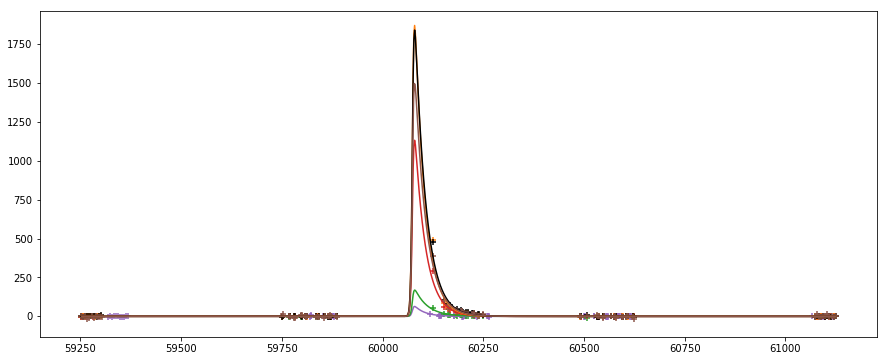

class 67 object_id =  3041
61117.0295 84 6.278737027813312 100.0
gap before
gap after
[21.975579597346595, 61067.0295, 20, 40]
[12.557474055626624, 60967.0295, 2.0, 4.0]
[31.393685139066562, 61067.0295, 200, 400]
result: 18.82 61053.98 55.10 36.21 median cov: 0
60538.2428 55 5.192554 3.1097999999983585
[13.760268100000001, 60533.2428, 5, 10]
[6.750320200000001, 60433.2428, 0.5, 1.0]
[20.770216, 60533.2428, 50, 100]
result: 6.98 60458.00 21.47 64.27 median cov: 176
60490.2647 50 18.512936 241.2309000000023
gap before
[64.795276, 60440.2647, 20, 40]
[37.025872, 60340.2647, 2.0, 4.0]
[92.56468, 60440.2647, 200, 400]
result: 89.91 60424.15 2.74 40.00 median cov: 0
60493.2527 51 17.764956 2.9724999999962165
[47.07713340000001, 60488.2527, 5, 10]
[23.094442800000003, 60388.2527, 0.5, 1.0]
[71.059824, 60488.2527, 50, 100]
result: 23.09 60482.27 3.24 41.05 median cov: 1
60493.2639 51 28.498444 2.9726000000009662
[75.5208766, 60488.2639, 5, 10]
[37.0479772, 60388.2639, 0.5, 1.0]
[113.993776, 60

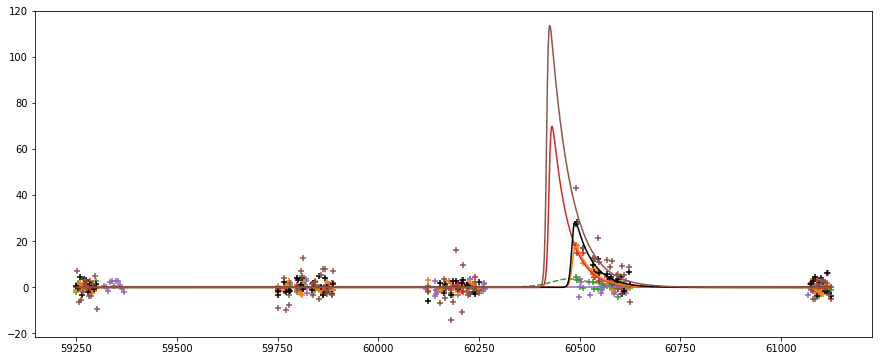

[60424.14903026453, 60482.26737990934, 60480.93887664806]
t00 60480.93887664806
12.56 4.00 median cov: -6820
6.75 45.83 median cov: -0
37.03 20.56 median cov: -0
23.26 41.75 median cov: -0
37.05 42.45 median cov: 0
86.21 18.82 median cov: -0


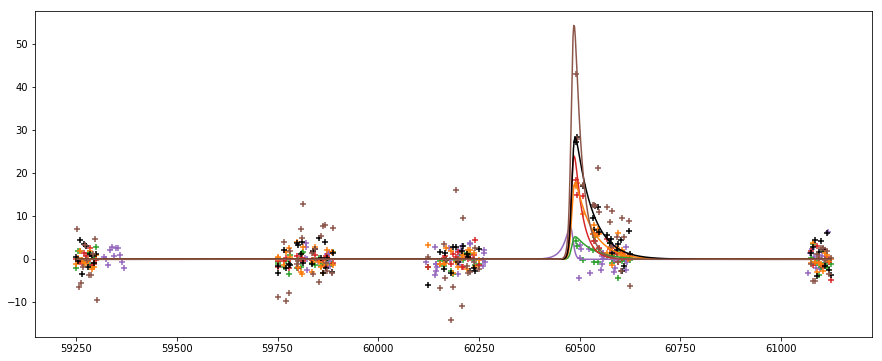

class 67 object_id =  19154
60141.2225 26 5.205078 0.9935000000041327
[13.7934567, 60136.2225, 5, 10]
[6.766601400000001, 60036.2225, 0.5, 1.0]
[20.820312, 60136.2225, 50, 100]
result: 6.79 60123.42 0.50 5.49 median cov: 250015139
60609.0323 66 40.330582 3.0020000000004075
[106.8760423, 60604.0323, 5, 10]
[52.429756600000005, 60504.0323, 0.5, 1.0]
[161.322328, 60604.0323, 50, 100]
result: 57.54 60604.03 1.58 12.81 median cov: 0
60609.0247 66 134.421982 3.002200000002631
[356.2182523, 60604.0247, 5, 10]
[174.74857660000004, 60504.0247, 0.5, 1.0]
[537.687928, 60604.0247, 50, 100]
result: 174.75 60604.02 1.84 24.76 median cov: 0
60609.04 66 195.192749 3.0020999999978812
[517.2607848499999, 60604.04, 5, 10]
[253.7505737, 60504.04, 0.5, 1.0]
[780.770996, 60604.04, 50, 100]
result: 253.75 60604.04 2.41 49.60 median cov: 0
60621.1996 67 191.90567 12.148600000000442
[508.55002549999995, 60616.1996, 5, 10]
[249.47737099999998, 60516.1996, 0.5, 1.0]
[767.62268, 60616.1996, 50, 100]
result: 288.3

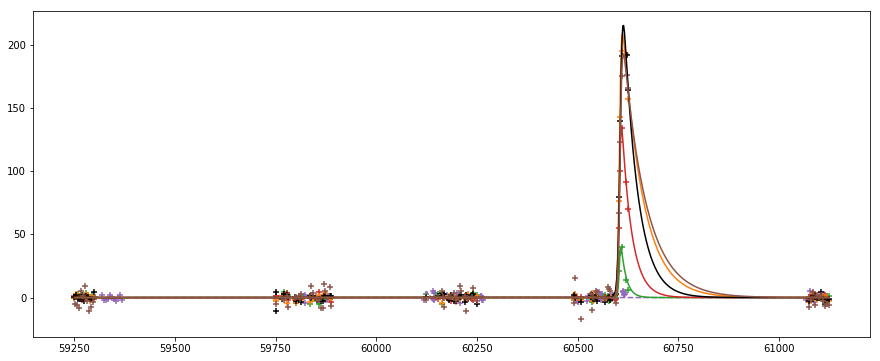

[60604.03229999999, 60604.024699999994, 60604.03999999999, 60606.25466659094]
t00 60604.03614999999
20.82 5.83 median cov: -0
57.66 13.59 median cov: -0
174.75 25.40 median cov: -0
253.75 47.98 median cov: 0
249.48 50.77 median cov: 0
228.78 55.82 median cov: 0


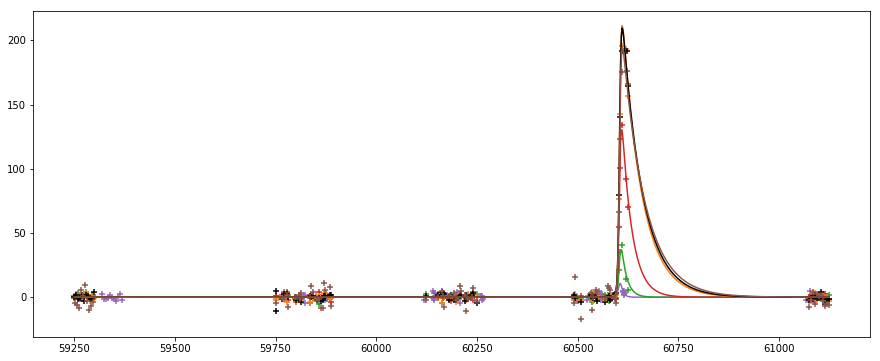

class 67 object_id =  28636
60612.1183 63 9.805061 23.951700000005076
[25.98341165, 60607.1183, 5, 10]
[12.7465793, 60507.1183, 0.5, 1.0]
[39.220244, 60607.1183, 50, 100]
result: 15.55 60589.68 0.50 28.44 median cov: 0
60605.1456 53 130.076782 8.956000000005588
[344.70347230000004, 60600.1456, 5, 10]
[169.09981660000003, 60500.1456, 0.5, 1.0]
[520.307128, 60600.1456, 50, 100]
result: 245.48 60598.37 1.77 10.97 median cov: 0
60605.138 53 344.063904 8.955999999998312
[911.7693456, 60600.138, 5, 10]
[447.2830752, 60500.138, 0.5, 1.0]
[1376.255616, 60600.138, 50, 100]
result: 532.23 60599.39 2.16 17.24 median cov: 0
60608.146 54 492.30481 2.9927999999999884
[1304.6077464999998, 60603.146, 5, 10]
[639.996253, 60503.146, 0.5, 1.0]
[1969.21924, 60603.146, 50, 100]
result: 766.86 60600.91 2.64 17.80 median cov: 0
60608.1569 54 423.81881699999997 2.9927000000025146
[1123.11986505, 60603.1569, 5, 10]
[550.9644621, 60503.1569, 0.5, 1.0]
[1695.2752679999999, 60603.1569, 50, 100]
result: 625.70 606

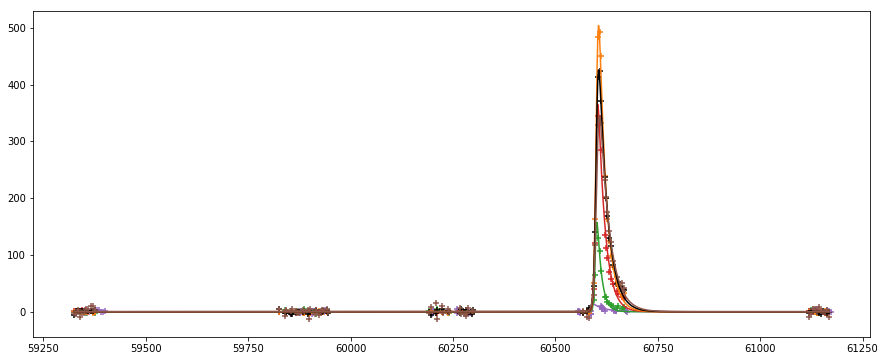

[60598.37467695102, 60599.38542429956, 60600.91118573858, 60600.56667829769]
t00 60599.976051298625
12.75 23.42 median cov: -0
232.11 10.34 median cov: -0
531.07 16.88 median cov: -0
756.92 18.61 median cov: -0
618.85 21.50 median cov: -0
483.02 26.40 median cov: -0


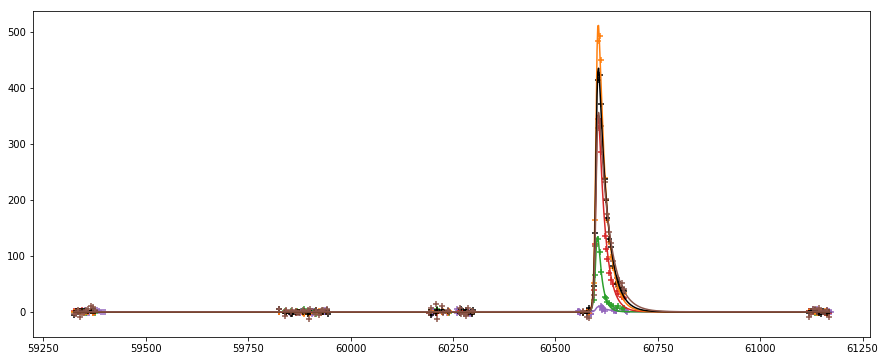

class 67 object_id =  34437
59582.3282 11 4.279237999999999 100.0
gap before
[14.977332999999998, 59532.3282, 20, 40]
[8.558475999999999, 59432.3282, 2.0, 4.0]
[21.396189999999997, 59532.3282, 200, 400]
result: 13.56 59510.07 61.48 32.76 median cov: 0
59947.3396 25 5.4109739999999995 253.33920000000217
gap before
[18.938409, 59897.3396, 20, 40]
[10.821947999999999, 59797.3396, 2.0, 4.0]
[27.054869999999998, 59897.3396, 200, 400]
result: 17.53 59876.50 2.00 42.28 median cov: 0
59947.332 25 21.072142000000003 253.33929999999964
gap before
[73.752497, 59897.332, 20, 40]
[42.144284000000006, 59797.332, 2.0, 4.0]
[105.36071000000001, 59897.332, 200, 400]
result: 86.79 59894.69 2.02 33.87 median cov: 0
59947.3472 25 59.543064 253.3391999999949
gap before
[208.40072400000003, 59897.3472, 20, 40]
[119.086128, 59797.3472, 2.0, 4.0]
[297.71532, 59897.3472, 200, 400]
result: 288.20 59896.97 2.00 29.85 median cov: 0
59947.3582 25 78.112511 253.33929999999964
gap before
[273.39378849999997, 59897.3

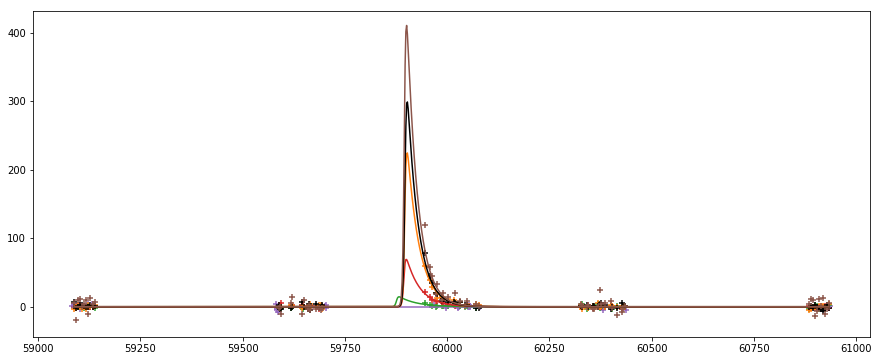

[59876.498206146076, 59894.68694200146, 59896.96635163483, 59897.35733066742]
t00 59895.82664681815
21.40 25.76 median cov: -20
11.01 42.48 median cov: -0
83.92 33.87 median cov: -0
297.72 29.93 median cov: -0
390.56 27.89 median cov: -1
535.42 26.78 median cov: -5


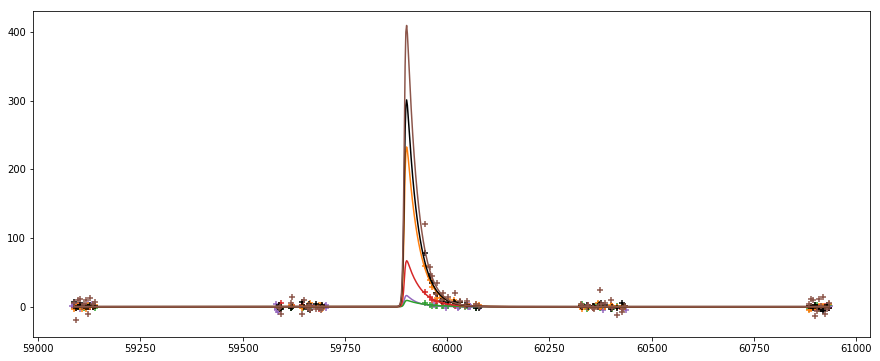

class 90
class 90 object_id =  745
60140.2403 31 18.014029 230.17179999999644
gap before
[63.0491015, 60090.2403, 20, 40]
[36.028058, 59990.2403, 2.0, 4.0]
[90.070145, 60090.2403, 200, 400]
result: 90.07 60063.58 16.82 42.67 median cov: 6
60125.4171 32 192.244293 223.31790000000183
gap before
[672.8550255, 60075.4171, 20, 40]
[384.488586, 59975.4171, 2.0, 4.0]
[961.221465, 60075.4171, 200, 400]
result: 961.22 60075.42 2.07 25.91 median cov: 0
60125.4094 32 220.79521200000002 223.31779999999708
gap before
[772.7832420000001, 60075.4094, 20, 40]
[441.59042400000004, 59975.4094, 2.0, 4.0]
[1103.9760600000002, 60075.4094, 200, 400]
result: 1103.68 60075.41 2.01 29.45 median cov: 0
60125.4248 32 203.250702 223.3179999999993
gap before
[711.377457, 60075.4248, 20, 40]
[406.501404, 59975.4248, 2.0, 4.0]
[1016.25351, 60075.4248, 200, 400]
result: 761.37 60075.42 16.24 40.21 median cov: 0
60125.4357 32 183.633118 223.31790000000183
gap before
[642.715913, 60075.4357, 20, 40]
[367.266236, 59975.

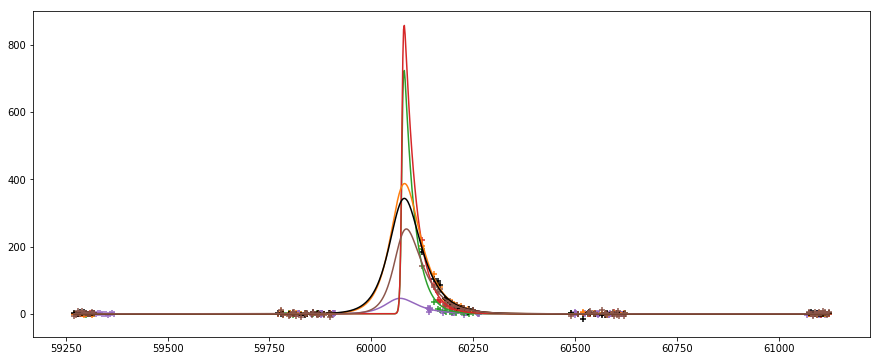

[60075.41709999999, 60075.40906504995, 60075.42479999999, 60075.435699999995]
t00 60075.42094999999
69.25 42.39 median cov: -0
961.22 26.49 median cov: -0
1103.98 29.71 median cov: -0
752.56 40.37 median cov: -0
662.63 41.79 median cov: -0
475.62 44.21 median cov: -0


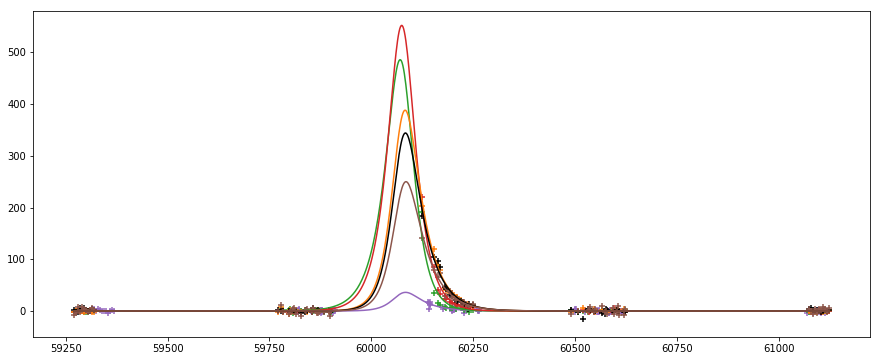

class 90 object_id =  1124
60499.2467 48 5.330927 235.2002000000066
gap before
[18.6582445, 60449.2467, 20, 40]
[10.661854, 60349.2467, 2.0, 4.0]
[26.654635, 60449.2467, 200, 400]
result: 10.66 60349.25 29.50 112.04 median cov: 46
60490.2725 50 37.170177 241.23099999999977
gap before
[130.0956195, 60440.2725, 20, 40]
[74.340354, 60340.2725, 2.0, 4.0]
[185.850885, 60440.2725, 200, 400]
result: 185.85 60385.00 18.24 62.84 median cov: 0
60490.2647 50 106.671692 241.2309000000023
gap before
[373.35092199999997, 60440.2647, 20, 40]
[213.343384, 60340.2647, 2.0, 4.0]
[533.3584599999999, 60440.2647, 200, 400]
result: 276.99 60440.26 2.00 48.62 median cov: 0
60490.2802 50 139.818405 241.23099999999977
gap before
[489.36441750000006, 60440.2802, 20, 40]
[279.63681, 60340.2802, 2.0, 4.0]
[699.092025, 60440.2802, 200, 400]
result: 547.92 60434.92 2.55 38.55 median cov: 8152
60490.2913 50 143.600189 241.23109999999724
gap before
[502.6006615, 60440.2913, 20, 40]
[287.200378, 60340.2913, 2.0, 4.0]


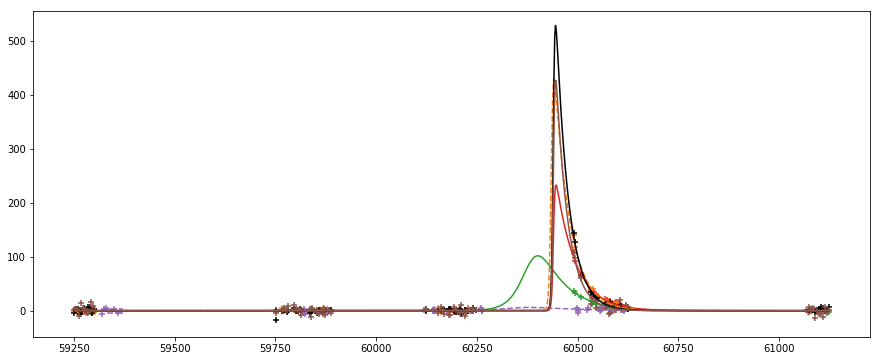

[60385.003149068805, 60440.26464163591, 60439.956993180655]
t00 60439.956993180655
10.66 58.44 median cov: -1
77.26 62.92 median cov: -0
278.74 48.62 median cov: -0
480.78 38.55 median cov: -0
673.07 31.85 median cov: -0
545.79 30.21 median cov: -1


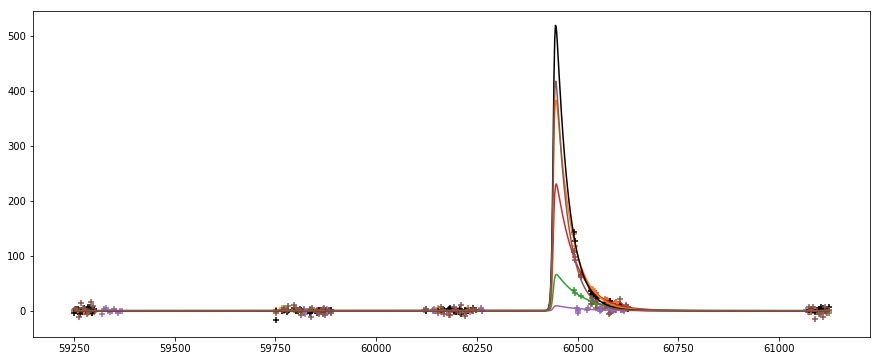

class 90 object_id =  1598
60617.0295 73 276.15957599999996 1.000499999994645
gap after
[966.5585159999998, 60612.0295, 20, 40]
[552.3191519999999, 60512.0295, 2.0, 4.0]
[1380.7978799999999, 60612.0295, 200, 400]
result: 552.32 60612.03 5.34 4.15 median cov: 0
60624.1836 68 1448.715698 3.002599999999802
gap after
[5070.504943, 60619.1836, 20, 40]
[2897.431396, 60519.1836, 2.0, 4.0]
[7243.57849, 60619.1836, 200, 400]
result: 2897.43 60619.18 2.00 8.85 median cov: 0
60624.176 68 1289.8514400000001 3.002599999999802
gap after
[4514.48004, 60619.176, 20, 40]
[2579.7028800000003, 60519.176, 2.0, 4.0]
[6449.257200000001, 60619.176, 200, 400]
result: 2579.70 60619.18 2.00 7.64 median cov: 0
60624.1913 68 1002.724548 3.002699999997276
gap after
[3509.535918, 60619.1913, 20, 40]
[2005.449096, 60519.1913, 2.0, 4.0]
[5013.62274, 60619.1913, 200, 400]
result: 2005.45 60619.19 2.00 7.17 median cov: 0
60624.2022 68 737.409363 3.002599999999802
gap after
[2580.9327704999996, 60619.2022, 20, 40]
[1474

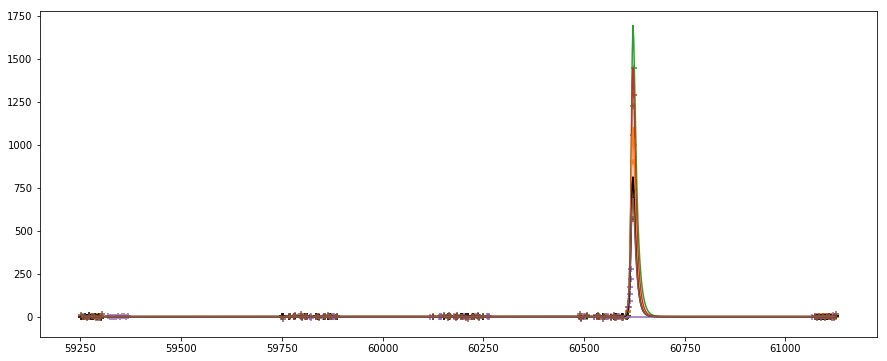

[60619.18359999999, 60619.17599999999, 60619.19129999999, 60619.20219999999]
t00 60619.18744999999
796.20 6.53 median cov: 0
2897.43 8.84 median cov: -0
2579.70 7.64 median cov: -0
2005.45 7.17 median cov: -0
1474.82 7.23 median cov: -0
1306.09 6.66 median cov: -0


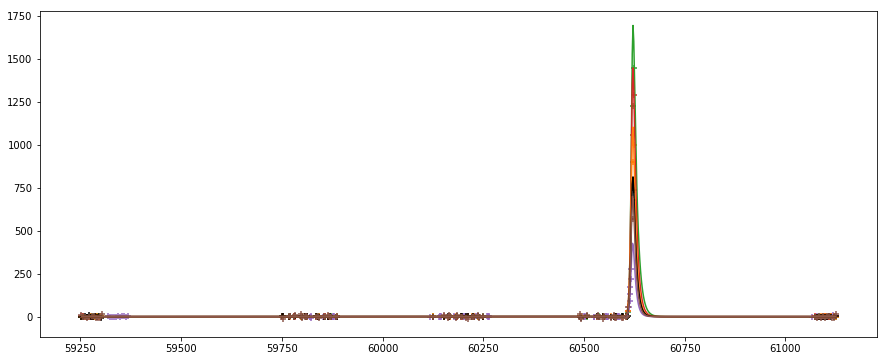

class 90 object_id =  1920
59999.1152 24 22.368911999999998 1.0054000000018277
[59.2776168, 59994.1152, 5, 10]
[29.079585599999998, 59894.1152, 0.5, 1.0]
[89.47564799999999, 59994.1152, 50, 100]
result: 41.44 59994.12 3.16 9.45 median cov: 0
59991.1226 31 195.06456 2.9817000000039116
[516.9210840000001, 59986.1226, 5, 10]
[253.58392800000001, 59886.1226, 0.5, 1.0]
[780.25824, 59986.1226, 50, 100]
result: 303.02 59986.12 2.88 18.73 median cov: 0
59991.115 31 231.828339 2.9816999999966356
[614.34509835, 59986.115, 5, 10]
[301.3768407, 59886.115, 0.5, 1.0]
[927.313356, 59986.115, 50, 100]
result: 358.29 59986.11 3.34 25.96 median cov: 0
60003.2462 32 225.627914 12.11590000000433
[597.9139721, 59998.2462, 5, 10]
[293.31628820000003, 59898.2462, 0.5, 1.0]
[902.511656, 59998.2462, 50, 100]
result: 337.96 59988.00 3.59 34.18 median cov: 0
60003.2572 32 188.361435 12.116000000001804
[499.15780275, 59998.2572, 5, 10]
[244.8698655, 59898.2572, 0.5, 1.0]
[753.44574, 59998.2572, 50, 100]
result: 2

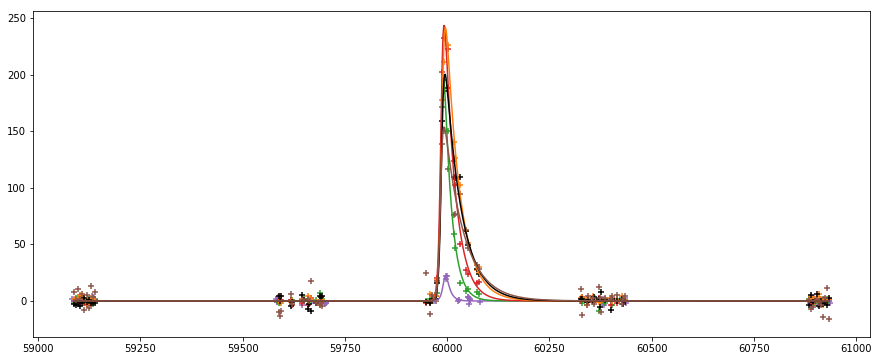

[59986.122599999995, 59986.11499999999, 59988.00302177018, 59986.75011885788]
t00 59986.43635942894
60.48 11.27 median cov: -0
313.31 18.23 median cov: -0
360.48 25.61 median cov: -0
307.82 38.36 median cov: -0
261.58 40.84 median cov: -0
198.68 45.02 median cov: -0


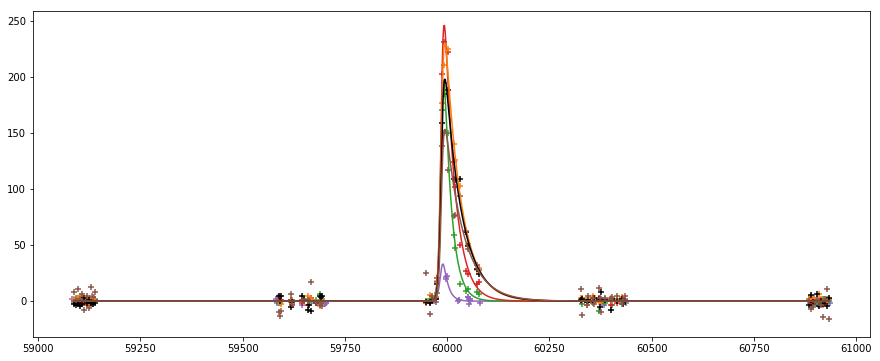

class 90 object_id =  2072
60556.0965 64 6.8506160000000005 0.9927000000025146
[18.1541324, 60551.0965, 5, 10]
[8.905800800000002, 60451.0965, 0.5, 1.0]
[27.402464000000002, 60551.0965, 50, 100]
result: 11.29 60546.47 3.32 2.66 median cov: 0
59779.4075 12 12.795062 9.03349999999773
[33.9069143, 59774.4075, 5, 10]
[16.633580600000002, 59674.4075, 0.5, 1.0]
[51.180248, 59774.4075, 50, 100]
result: 35.33 59682.63 23.42 76.35 median cov: 470
59770.3662 11 19.92598 100.0
gap before
[69.74092999999999, 59720.3662, 20, 40]
[39.85196, 59620.3662, 2.0, 4.0]
[99.62989999999999, 59720.3662, 200, 400]
result: 42.59 59720.36 2.09 64.09 median cov: 0
59770.3817 11 16.612894 100.0
gap before
[58.145129, 59720.3817, 20, 40]
[33.225788, 59620.3817, 2.0, 4.0]
[83.06447, 59720.3817, 200, 400]
result: 55.68 59720.38 25.01 44.44 median cov: 2
59770.3928 11 18.105003 100.0
gap before
[63.367510499999995, 59720.3928, 20, 40]
[36.210006, 59620.3928, 2.0, 4.0]
[90.525015, 59720.3928, 200, 400]
result: 45.10 59

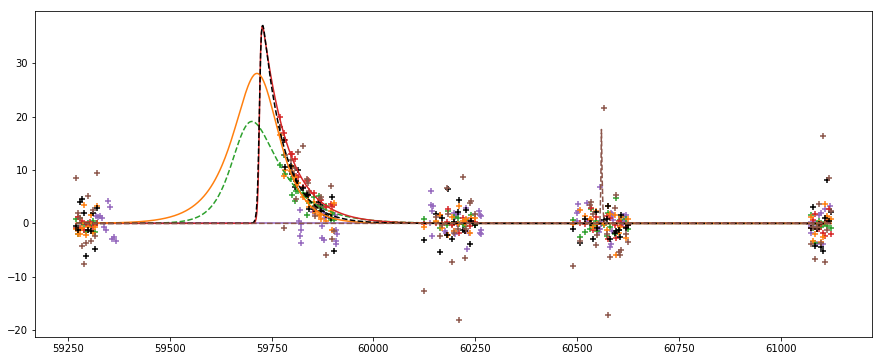

[59720.36165011012, 59720.381694004696]
t00 59720.37167205741
11.29 2.66 median cov: 0
20.88 77.74 median cov: -0
42.59 64.09 median cov: -0
45.91 47.77 median cov: -0
45.12 52.24 median cov: -0
32.53 1.82 median cov: 0


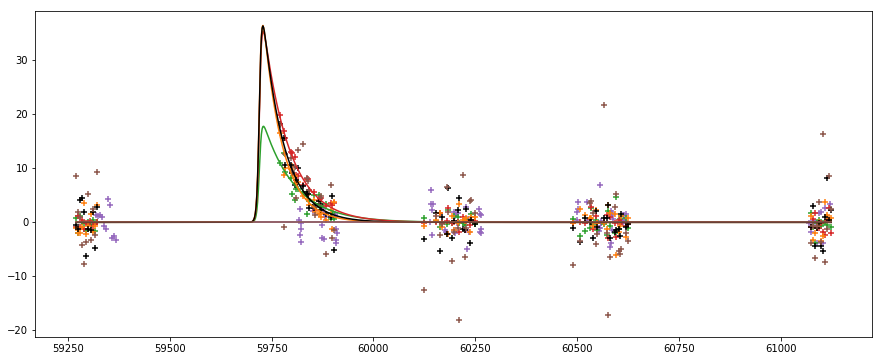

In [5]:
for class_ in [15, 42, 52, 62, 67, 90]:
    print('class', class_)
    for object_id in train[train.target==class_].object_id.unique()[:5]:
        print('class', class_, end=' ')
        plot_bazin(object_id)

class 64
class 64 object_id =  62187
59323.274 1 6.169788495472132 100.0
gap before
gap after
[21.594259734152462, 59273.274, 20, 40]
[12.339576990944265, 59173.274, 2.0, 4.0]
[30.848942477360662, 59273.274, 200, 400]
result: 20.44 59260.18 35.35 34.65 median cov: 0
60538.2903 49 3.408588 3.0023999999975786
[9.0327582, 60533.2903, 5, 10]
[4.4311644, 60433.2903, 0.5, 1.0]
[13.634352, 60533.2903, 50, 100]
result: 4.43 60533.29 0.50 15.80 median cov: 2
60580.1736 51 24.257456 12.844499999999243
[64.2822584, 60575.1736, 5, 10]
[31.534692800000002, 60475.1736, 0.5, 1.0]
[97.029824, 60575.1736, 50, 100]
result: 63.05 60575.17 1.29 5.35 median cov: 2
60580.1889 51 36.89312 12.844499999999243
[97.76676800000001, 60575.1889, 5, 10]
[47.961056000000006, 60475.1889, 0.5, 1.0]
[147.57248, 60575.1889, 50, 100]
result: 147.57 60575.19 1.13 3.60 median cov: 58
60580.1999 50 21.121261999999998 12.844599999996717
[55.9713443, 60575.1999, 5, 10]
[27.457640599999998, 60475.1999, 0.5, 1.0]
[84.48504799999

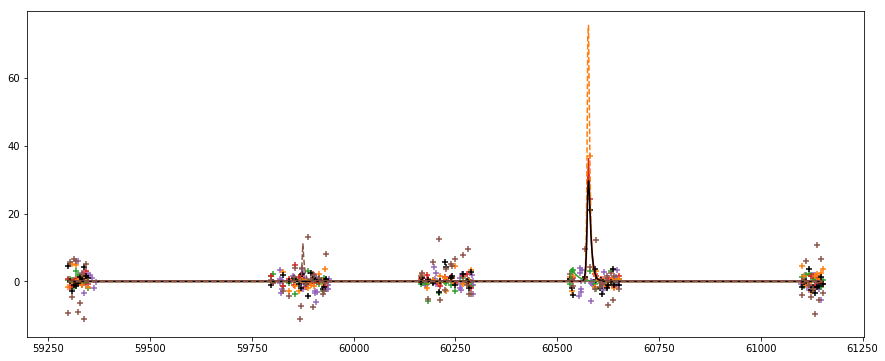

[60533.29029999999, 60575.17359973921, 60575.19989999999]
t00 60575.17359973921
12.34 4.00 median cov: -11
13.63 3.41 median cov: -4
63.22 5.31 median cov: -0
147.57 3.64 median cov: -1
54.09 5.51 median cov: -1
28.28 1.81 median cov: 5


/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in multiply


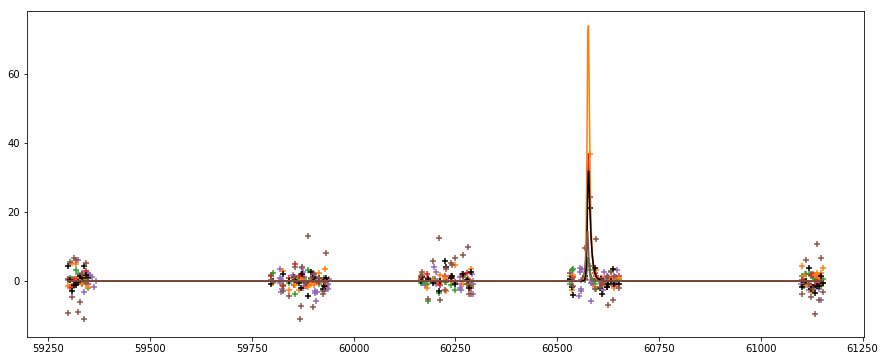

class 64 object_id =  139362
60911.984 46 3.8281808063811247 100.0
gap before
gap after
[13.398632822333937, 60861.984, 20, 40]
[7.656361612762249, 60761.984, 2.0, 4.0]
[19.140904031905624, 60861.984, 200, 400]
result: 12.59 60846.44 41.72 33.94 median cov: 0
59688.0047 22 6.683827000000001 8.98979999999574
[17.712141550000002, 59683.0047, 5, 10]
[8.688975100000002, 59583.0047, 0.5, 1.0]
[26.735308000000003, 59683.0047, 50, 100]
result: 8.77 59666.84 0.50 2.10 median cov: 9079
60016.0879 33 26.878651 12.85689999999886
[71.22842515, 60011.0879, 5, 10]
[34.9422463, 59911.0879, 0.5, 1.0]
[107.514604, 60011.0879, 50, 100]
result: 62.26 60011.09 1.08 6.08 median cov: 0
60016.1032 33 44.678298999999996 12.856999999996333
[118.39749235, 60011.1032, 5, 10]
[58.0817887, 59911.1032, 0.5, 1.0]
[178.71319599999998, 60011.1032, 50, 100]
result: 120.73 60011.10 1.28 5.18 median cov: 0
60016.1141 33 13.835822 12.85689999999886
[36.6649283, 60011.1141, 5, 10]
[17.986568600000002, 59911.1141, 0.5, 1.0]

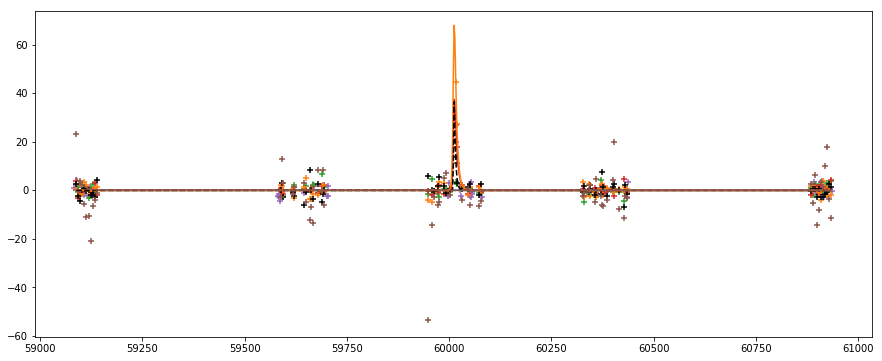

[60011.08789999999, 60011.10319999999]
t00 60011.09554999999
7.66 4.00 median cov: -1716
8.69 6.46 median cov: -0
62.55 6.07 median cov: -0
120.25 5.19 median cov: -0
55.34 3.48 median cov: -2
71.87 4.00 median cov: -9


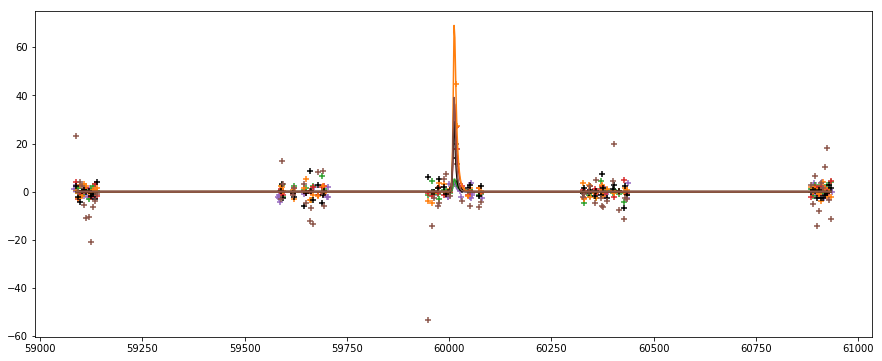

class 64 object_id =  1573501
59874.2948 13 263.333282 22.927600000002712
[697.8331972999999, 59869.2948, 5, 10]
[342.3332666, 59769.2948, 0.5, 1.0]
[1053.333128, 59869.2948, 50, 100]
result: 1053.33 59869.29 2.78 4.05 median cov: 2164867
59430.229 0 39.85159825923676 100.0
gap before
gap after
[139.48059390732865, 59380.229, 20, 40]
[79.70319651847352, 59280.229, 2.0, 4.0]
[199.2579912961838, 59380.229, 200, 400]
result: 128.16 59359.89 37.29 32.19 median cov: 0
60616.2673 30 164.10514799999999 26.925799999997253
[434.87864219999994, 60611.2673, 5, 10]
[213.33669239999998, 60511.2673, 0.5, 1.0]
[656.4205919999999, 60611.2673, 50, 100]
result: 563.70 60609.46 0.70 5.52 median cov: 617080
60064.076 25 87.724426 22.01520000000164
[232.46972889999998, 60059.076, 5, 10]
[114.0417538, 59959.076, 0.5, 1.0]
[350.897704, 60059.076, 50, 100]
result: 350.90 60059.08 0.50 3.14 median cov: 332419066479743
60601.3756 36 739.345215 21.987300000000687
[1959.2648197500002, 60596.3756, 5, 10]
[961.1487

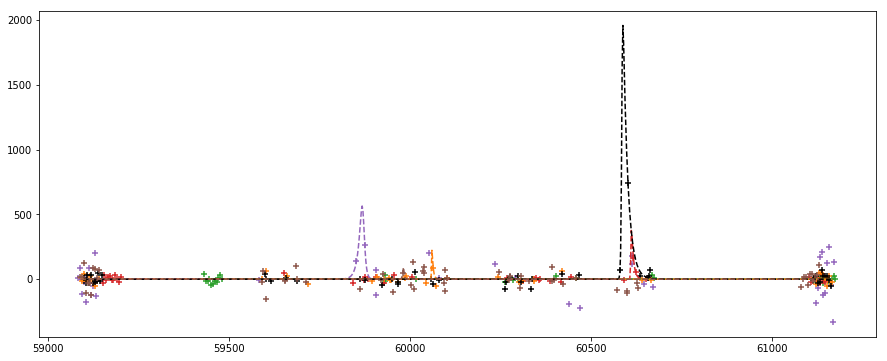

[59359.893078245594]
class 64 object_id =  3572446
59195.1505 10 13.389145739340425 100.0
gap before
gap after
[46.86201008769149, 59145.1505, 20, 40]
[26.77829147868085, 59045.1505, 2.0, 4.0]
[66.94572869670212, 59145.1505, 200, 400]
result: 40.78 59129.09 56.22 34.50 median cov: 0
60487.99 19 42.954063 26.901099999995495
[113.82826695, 60482.99, 5, 10]
[55.8402819, 60382.99, 0.5, 1.0]
[171.816252, 60482.99, 50, 100]
result: 171.82 60481.66 2.30 4.78 median cov: 6
60492.0678 26 142.39505 33.97179999999935
gap after
[498.38267499999995, 60487.0678, 20, 40]
[284.7901, 60387.0678, 2.0, 4.0]
[711.97525, 60487.0678, 200, 400]
result: 284.79 60485.34 2.00 10.20 median cov: 2247061561865629
60485.0349 29 692.9979860000001 25.860099999998056
gap after
[2425.492951, 60480.0349, 20, 40]
[1385.9959720000002, 60380.0349, 2.0, 4.0]
[3464.9899300000006, 60480.0349, 200, 400]
result: 1386.00 60480.03 2.01 8.15 median cov: 1
60426.086 32 19.463221 60.74790000000212
gap before
[68.1212735, 60376.086, 

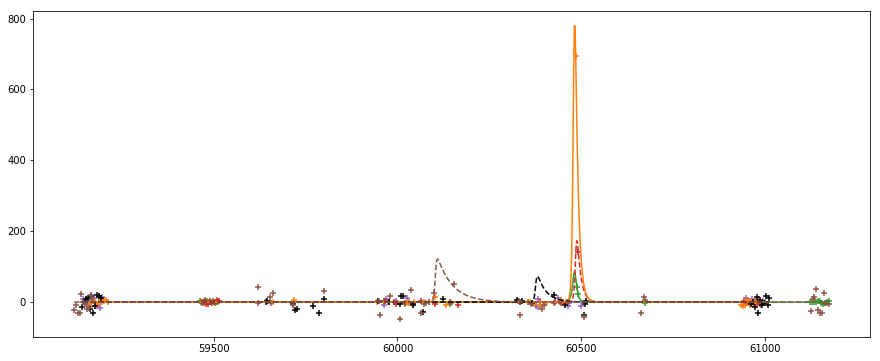

[60481.66228414341, 60480.033047030214]
t00 60480.847665586814
26.78 4.23 median cov: 27
171.82 5.23 median cov: -2
284.79 16.27 median cov: -543881
1386.00 7.26 median cov: -877
38.94 4.06 median cov: 4081
103.57 4.00 median cov: -7452556767


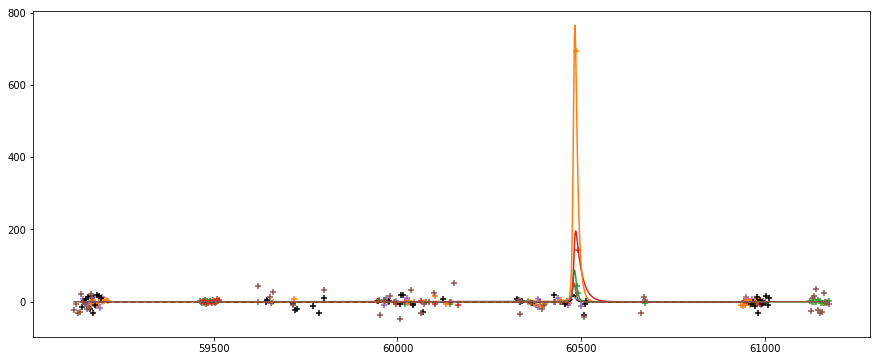

class 64 object_id =  4311960
59296.0295 1 17.5371002948519 100.0
gap before
gap after
[61.379851031981644, 59246.0295, 20, 40]
[35.0742005897038, 59146.0295, 2.0, 4.0]
[87.6855014742595, 59246.0295, 200, 400]
result: 56.86 59227.58 37.13 32.60 median cov: 0
59807.0006 13 8.175367999999999 16.9574999999968
gap after
[28.613787999999996, 59802.0006, 20, 40]
[16.350735999999998, 59702.0006, 2.0, 4.0]
[40.876839999999994, 59802.0006, 200, 400]
result: 16.35 59802.00 6.96 100.89 median cov: 295
60018.3873 16 28.714465999999998 16.136200000000827
[76.0933349, 60013.3873, 5, 10]
[37.3288058, 59913.3873, 0.5, 1.0]
[114.85786399999999, 60013.3873, 50, 100]
result: 114.81 60010.42 1.36 5.75 median cov: 41
60928.2233 30 21.958821695596512 100.0
gap before
gap after
[76.8558759345878, 60878.2233, 20, 40]
[43.917643391193025, 60778.2233, 2.0, 4.0]
[109.79410847798256, 60878.2233, 200, 400]
result: 71.45 60861.78 49.80 34.14 median cov: 0
60010.4048 25 332.01730299999997 4.159799999993993
gap after

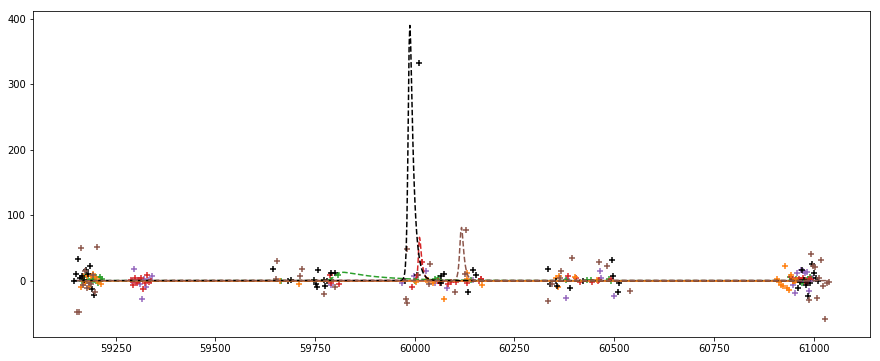

[60861.77782821557]
class 88
class 88 object_id =  713
59905.0468 20 14.509829000000002 0.9883999999947264
[38.451046850000004, 59900.0468, 5, 10]
[18.862777700000002, 59800.0468, 0.5, 1.0]
[58.03931600000001, 59900.0468, 50, 100]
result: 18.86 59899.83 7.18 16.73 median cov: 0
59916.0621 25 9.129021 2.809900000000198
[24.19190565, 59911.0621, 5, 10]
[11.8677273, 59811.0621, 0.5, 1.0]
[36.516084, 59911.0621, 50, 100]
result: 12.32 59911.06 12.66 18.61 median cov: 5
59916.0544 25 10.529041000000001 2.809800000002724
[27.901958650000005, 59911.0544, 5, 10]
[13.687753300000002, 59811.0544, 0.5, 1.0]
[42.116164000000005, 59911.0544, 50, 100]
result: 13.69 59911.05 10.43 14.36 median cov: 3
59902.0598 23 11.330316 2.959100000000035
[30.025337399999998, 59897.0598, 5, 10]
[14.7294108, 59797.0598, 0.5, 1.0]
[45.321264, 59897.0598, 50, 100]
result: 14.73 59897.06 12.15 29.64 median cov: 1
59916.0806 25 9.827933999999999 2.809800000002724
[26.0440251, 59911.0806, 5, 10]
[12.7763142, 59811.0806,

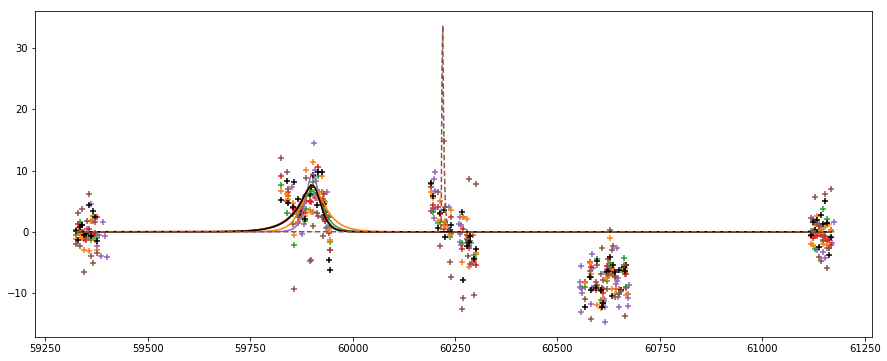

[59911.062099999996, 59911.05439999999, 59897.059799999995, 59911.080599999994]
t00 59911.058249999995
18.86 18.35 median cov: 1
13.98 15.09 median cov: 0
13.69 13.87 median cov: 0
15.49 16.96 median cov: 0
13.20 13.75 median cov: 0
59.08 3.26 median cov: 0


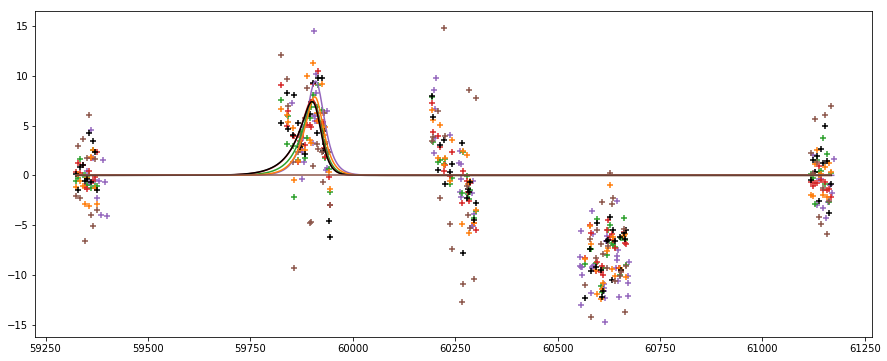

class 88 object_id =  3489
59582.3282 11 17.009882 100.0
gap before
[59.534587, 59532.3282, 20, 40]
[34.019764, 59432.3282, 2.0, 4.0]
[85.04941000000001, 59532.3282, 200, 400]
result: 34.02 59506.86 35.87 65.34 median cov: 206
59618.2024 14 12.235389999999999 23.930400000004738
[32.4237835, 59613.2024, 5, 10]
[15.906006999999999, 59513.2024, 0.5, 1.0]
[48.941559999999996, 59613.2024, 50, 100]
result: 22.12 59595.34 7.82 37.79 median cov: 7
59687.9971 22 9.781057 8.989800000003015
[25.919801050000004, 59682.9971, 5, 10]
[12.715374100000002, 59582.9971, 0.5, 1.0]
[39.124228, 59682.9971, 50, 100]
result: 17.48 59598.26 28.55 53.49 median cov: 79
59588.2343 11 9.618625999999999 100.0
gap before
[33.66519099999999, 59538.2343, 20, 40]
[19.237251999999998, 59438.2343, 2.0, 4.0]
[48.093129999999995, 59538.2343, 200, 400]
result: 22.55 59538.23 29.35 65.14 median cov: 1108
59621.1553 15 9.753960000000001 2.9343000000008033
[25.847994000000003, 59616.1553, 5, 10]
[12.680148000000003, 59516.1553

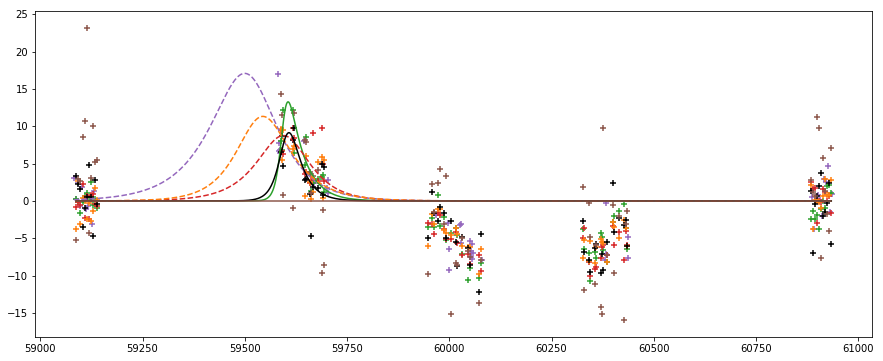

[59595.34113954582, 59602.071528673936]
t00 59598.70633410988
34.02 50.00 median cov: 1
18.43 47.23 median cov: -0
17.45 53.42 median cov: -1
19.24 42.81 median cov: -0
14.37 43.17 median cov: -0
46.42 32.95 median cov: 0


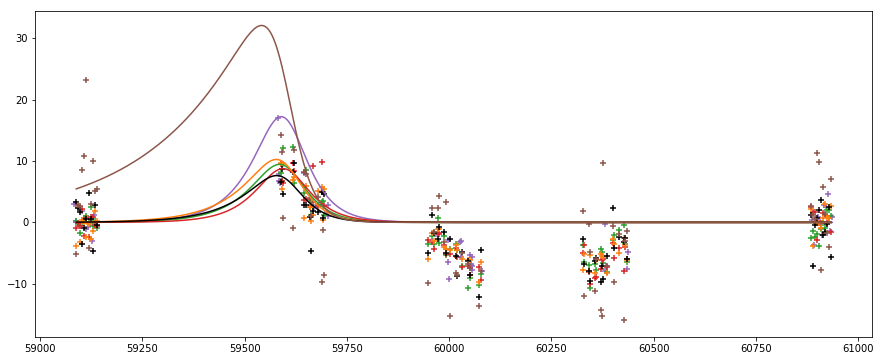

class 88 object_id =  4088
61115.1257 92 4.795442586814448 100.0
gap before
gap after
[16.78404905385057, 61065.1257, 20, 40]
[9.590885173628896, 60965.1257, 2.0, 4.0]
[23.97721293407224, 61065.1257, 200, 400]
result: 14.87 61048.19 49.37 34.73 median cov: 0
59295.374 5 1.504747563187455 100.0
gap before
gap after
[5.266616471156093, 59245.374, 20, 40]
[3.00949512637491, 59145.374, 2.0, 4.0]
[7.523737815937275, 59245.374, 200, 400]
result: 4.90 59231.09 53.36 35.47 median cov: 0
61089.0348 70 3.3138973385717483 100.0
gap before
gap after
[11.598640685001119, 61039.0348, 20, 40]
[6.627794677143497, 60939.0348, 2.0, 4.0]
[16.569486692858742, 61039.0348, 200, 400]
result: 7.28 60978.61 68.23 24.42 median cov: 0
59280.3817 2 2.692897854064555 100.0
gap before
gap after
[9.425142489225943, 59230.3817, 20, 40]
[5.38579570812911, 59130.3817, 2.0, 4.0]
[13.464489270322774, 59230.3817, 200, 400]
result: 8.81 59216.49 56.59 35.87 median cov: 0
59285.3928 3 3.8020129258286053 100.0
gap before
gap

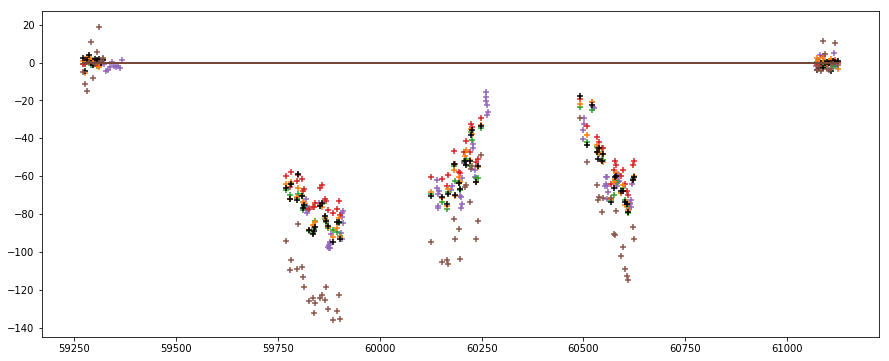

[59231.088455958496, 60978.60682220312, 59216.493885943644, 59223.66959910888]
t00 59227.37902753369
14.87 34.73 median cov: 0
4.90 35.47 median cov: 0
7.28 24.42 median cov: 0
8.81 35.87 median cov: 0
12.56 36.74 median cov: 0
58.44 36.67 median cov: 0


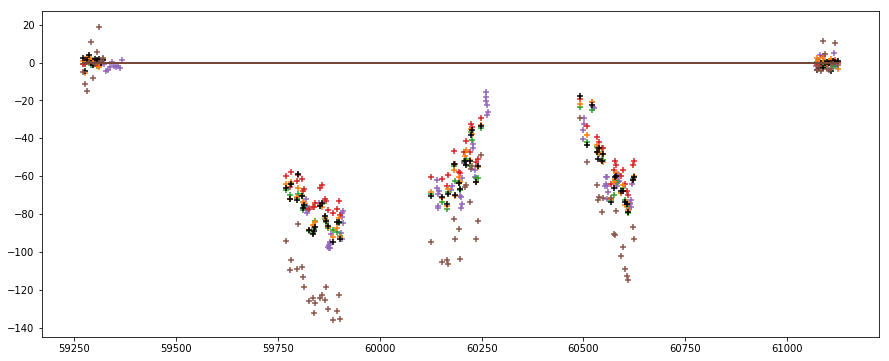

class 88 object_id =  7315
60499.2579 56 1186.7071529999998 234.21919999999955
gap before
[4153.4750355, 60449.2579, 20, 40]
[2373.4143059999997, 60349.2579, 2.0, 4.0]
[5933.535764999999, 60449.2579, 200, 400]
result: 5135.85 60449.26 13.06 38.66 median cov: 1
60491.3523 48 1243.337524 242.2632999999987
gap before
[4351.681334000001, 60441.3523, 20, 40]
[2486.675048, 60341.3523, 2.0, 4.0]
[6216.687620000001, 60441.3523, 200, 400]
result: 5367.83 60441.35 14.21 42.11 median cov: 2
60491.3446 48 1383.304443 242.2632999999987
gap before
[4841.5655504999995, 60441.3446, 20, 40]
[2766.608886, 60341.3446, 2.0, 4.0]
[6916.522215, 60441.3446, 200, 400]
result: 6219.42 60441.34 14.22 41.45 median cov: 2
60491.36 48 1930.695312 242.26340000000346
gap before
[6757.433592, 60441.36, 20, 40]
[3861.390624, 60341.36, 2.0, 4.0]
[9653.476560000001, 60441.36, 200, 400]
result: 8577.87 60441.36 14.28 41.76 median cov: 1
60491.3711 48 1846.404175 242.26349999999366
gap before
[6462.4146125, 60441.3711, 20

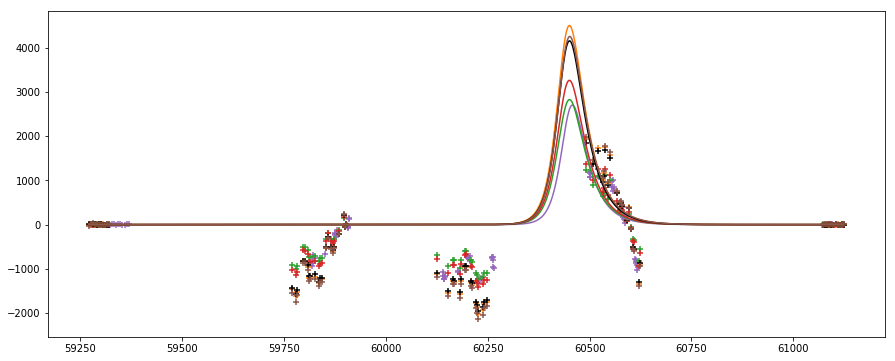

[60441.35229999999, 60441.34459999999, 60441.35999999999, 60441.37109999999]
t00 60441.35614999999
5933.54 39.74 median cov: -22
5548.82 41.51 median cov: -15
6478.21 40.76 median cov: -16
8923.23 41.08 median cov: -23
8201.40 41.32 median cov: -24
8264.40 42.59 median cov: -31


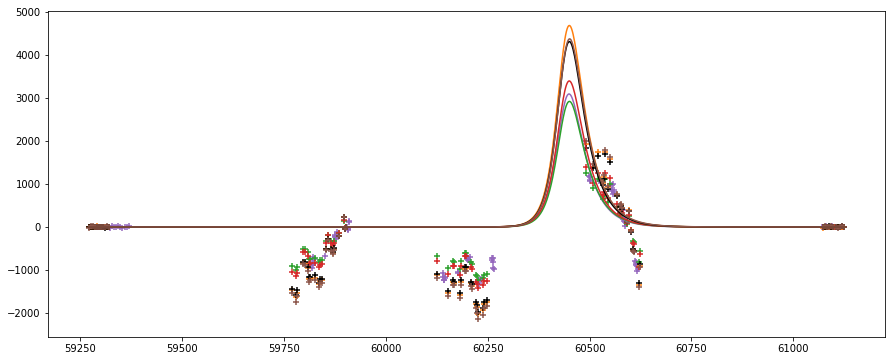

class 88 object_id =  7409
59874.0599 17 7.082586 22.948499999998603
[18.7688529, 59869.0599, 5, 10]
[9.207361800000001, 59769.0599, 0.5, 1.0]
[28.330344, 59869.0599, 50, 100]
result: 28.33 59868.59 2.25 3.72 median cov: 0
59779.3265 15 18.855591 9.100900000004913
[49.96731615, 59774.3265, 5, 10]
[24.512268300000002, 59674.3265, 0.5, 1.0]
[75.422364, 59774.3265, 50, 100]
result: 30.18 59774.33 45.17 74.28 median cov: 2
59782.1897 16 23.62244 2.8709000000017113
[62.59946600000001, 59777.1897, 5, 10]
[30.709172000000002, 59677.1897, 0.5, 1.0]
[94.48976, 59777.1897, 50, 100]
result: 41.90 59777.19 47.21 78.88 median cov: 3
59782.2051 16 25.217247 2.8709000000017113
[66.82570455, 59777.2051, 5, 10]
[32.7824211, 59677.2051, 0.5, 1.0]
[100.868988, 59777.2051, 50, 100]
result: 43.14 59777.21 44.30 76.07 median cov: 1
59750.445 11 34.641533 100.0
gap before
[121.24536550000002, 59700.445, 20, 40]
[69.283066, 59600.445, 2.0, 4.0]
[173.20766500000002, 59700.445, 200, 400]
result: 69.28 59640.02 

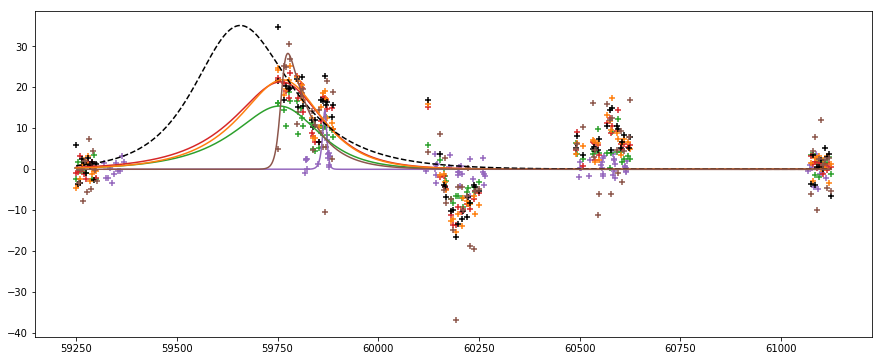

[59774.326499987365, 59777.189699999995, 59777.20509226847]
t00 59777.189699999995
28.33 3.72 median cov: 0
29.94 72.79 median cov: -0
42.06 77.23 median cov: -0
43.10 76.40 median cov: -0
69.28 61.91 median cov: 0
41.51 68.95 median cov: -0


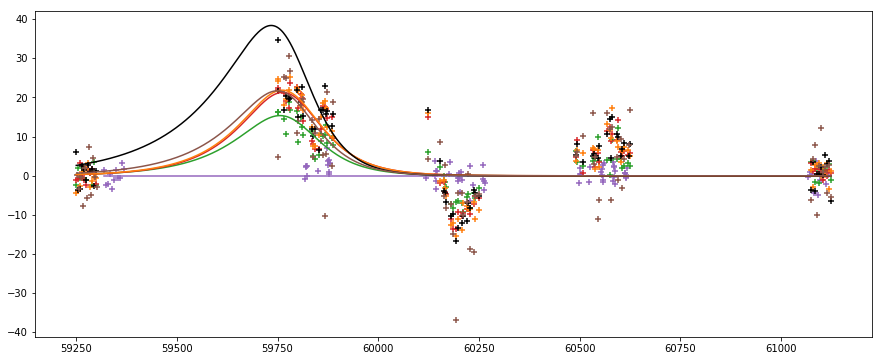

class 95
class 95 object_id =  3423
60560.1065 60 7.71422 0.9968000000008033
[20.442683000000002, 60555.1065, 5, 10]
[10.028486000000001, 60455.1065, 0.5, 1.0]
[30.85688, 60555.1065, 50, 100]
result: 11.92 60537.60 1.34 1.72 median cov: 9173862
59800.3244 18 6.21014 3.0305999999982305
[16.456871, 59795.3244, 5, 10]
[8.073182000000001, 59695.3244, 0.5, 1.0]
[24.84056, 59795.3244, 50, 100]
result: 8.14 59790.13 0.50 1.06 median cov: 1549188
60124.2541 33 7.741397 237.22430000000168
gap before
[27.0948895, 60074.2541, 20, 40]
[15.482794, 59974.2541, 2.0, 4.0]
[38.706985, 60074.2541, 200, 400]
result: 29.48 60070.56 2.14 36.61 median cov: 0
60124.2695 33 22.242645 237.22439999999915
gap before
[77.8492575, 60074.2695, 20, 40]
[44.48529, 59974.2695, 2.0, 4.0]
[111.213225, 60074.2695, 200, 400]
result: 103.39 60040.59 3.48 52.01 median cov: 0
60124.2807 33 39.706257 237.2245000000039
gap before
[138.9718995, 60074.2807, 20, 40]
[79.412514, 59974.2807, 2.0, 4.0]
[198.531285, 60074.2807, 200, 

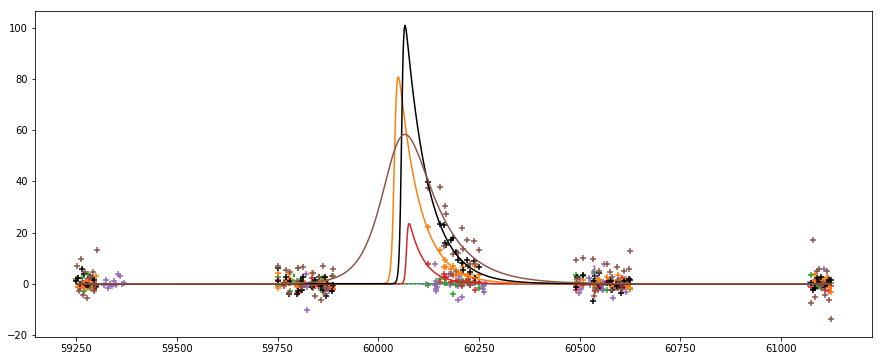

[60070.564328227745, 60040.594119428155, 60058.27218847228]
t00 60058.27218847228
11.92 1.72 median cov: 0
8.14 1.06 median cov: 0
38.71 37.45 median cov: -2
73.59 52.01 median cov: -1
122.12 57.30 median cov: -1
87.89 84.02 median cov: -1


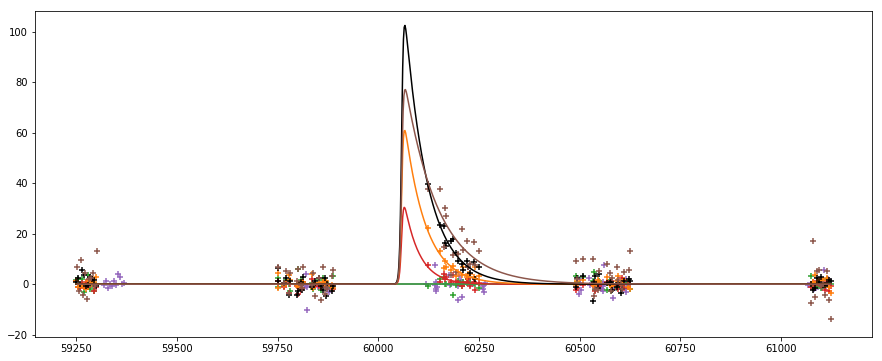

class 95 object_id =  10321
60560.1152 68 108.10068500000001 0.996899999998277
[286.46681525, 60555.1152, 5, 10]
[140.53089050000003, 60455.1152, 0.5, 1.0]
[432.40274000000005, 60555.1152, 50, 100]
result: 187.35 60551.58 12.48 61.90 median cov: 0
60577.0738 58 210.599579 2.8900999999968917
[558.0888843500001, 60572.0738, 5, 10]
[273.77945270000004, 60472.0738, 0.5, 1.0]
[842.398316, 60572.0738, 50, 100]
result: 325.97 60551.45 14.72 100.00 median cov: 0
60596.0872 61 330.83547999999996 3.0714000000007218
[876.7140219999999, 60591.0872, 5, 10]
[430.086124, 60491.0872, 0.5, 1.0]
[1323.3419199999998, 60591.0872, 50, 100]
result: 531.09 60561.21 16.62 100.00 median cov: 0
60603.0839 62 365.325134 6.981199999994715
[968.1116051, 60598.0839, 5, 10]
[474.9226742, 60498.0839, 0.5, 1.0]
[1461.300536, 60598.0839, 50, 100]
result: 597.60 60569.65 18.75 100.00 median cov: 0
60609.0987 64 364.413727 3.0020000000004075
[965.69637655, 60604.0987, 5, 10]
[473.7378451, 60504.0987, 0.5, 1.0]
[1457.6549

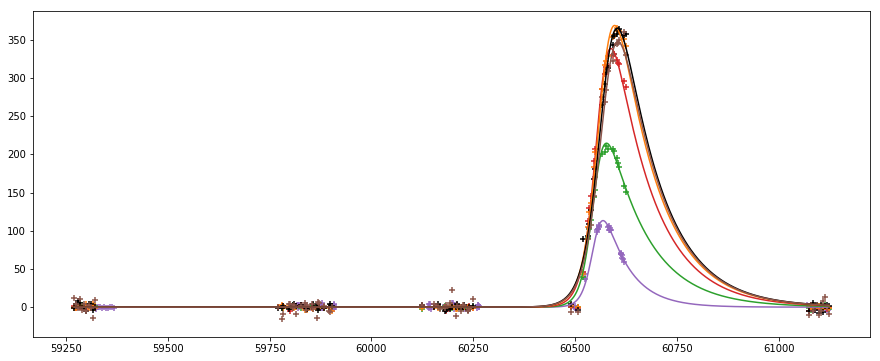

[60551.449460315576, 60561.207683266766, 60569.65011056674, 60575.88929490315]
t00 60565.428896916754
207.60 47.30 median cov: -0
389.35 64.53 median cov: -0
556.39 90.29 median cov: -0
583.34 100.00 median cov: -0
570.20 100.00 median cov: -0
545.57 100.00 median cov: -0


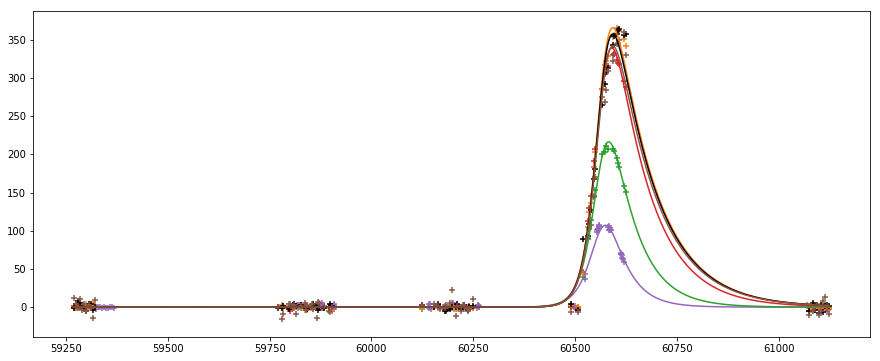

class 95 object_id =  14553
60620.1257 82 200.889099 3.0872999999992317
gap after
[703.1118465, 60615.1257, 20, 40]
[401.778198, 60515.1257, 2.0, 4.0]
[1004.4454949999999, 60615.1257, 200, 400]
result: 401.78 60612.51 7.81 18.59 median cov: 0
60624.0425 66 249.497421 2.814700000002631
gap after
[873.2409735, 60619.0425, 20, 40]
[498.994842, 60519.0425, 2.0, 4.0]
[1247.487105, 60619.0425, 200, 400]
result: 498.99 60611.26 7.15 22.04 median cov: 0
60624.0348 66 310.562775 2.8145999999978812
gap after
[1086.9697124999998, 60619.0348, 20, 40]
[621.12555, 60519.0348, 2.0, 4.0]
[1552.8138749999998, 60619.0348, 200, 400]
result: 621.13 60613.20 7.17 20.63 median cov: 0
60624.0502 66 286.72805800000003 2.814699999995355
gap after
[1003.5482030000002, 60619.0502, 20, 40]
[573.4561160000001, 60519.0502, 2.0, 4.0]
[1433.6402900000003, 60619.0502, 200, 400]
result: 573.46 60615.35 7.53 20.33 median cov: 0
60624.0612 66 257.29614300000003 2.814799999992829
gap after
[900.5365005000001, 60619.0612, 

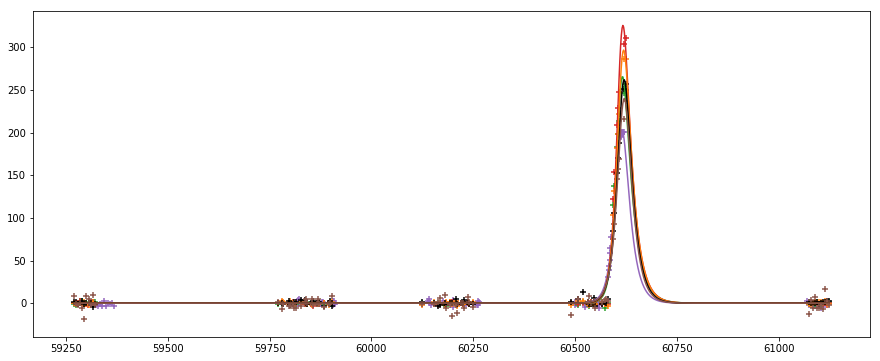

[60611.25784183821, 60613.19552529082, 60615.34669944225, 60617.6372347844]
t00 60614.271112366536
401.78 16.35 median cov: 0
513.61 19.84 median cov: 0
621.13 21.25 median cov: 0
573.46 22.45 median cov: 0
514.59 23.87 median cov: 0
475.14 23.45 median cov: 0


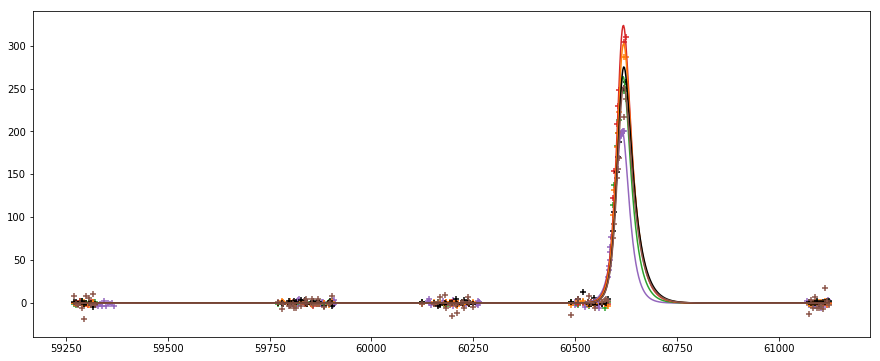

class 95 object_id =  23539
60582.1681 62 1195.25647 21.941300000005867
[3167.4296455000003, 60577.1681, 5, 10]
[1553.833411, 60477.1681, 0.5, 1.0]
[4781.02588, 60577.1681, 50, 100]
result: 2367.51 60571.46 12.06 30.34 median cov: 0
60580.1813 51 1585.4179689999999 12.844499999999243
[4201.35761785, 60575.1813, 5, 10]
[2061.0433597, 60475.1813, 0.5, 1.0]
[6341.671875999999, 60575.1813, 50, 100]
result: 2533.39 60565.63 6.69 53.87 median cov: 0
60593.1209 52 1549.000977 12.947299999999814
[4104.85258905, 60588.1209, 5, 10]
[2013.7012700999999, 60488.1209, 0.5, 1.0]
[6196.003908, 60588.1209, 50, 100]
result: 2178.96 60565.03 7.28 90.92 median cov: 0
60593.1365 52 1437.070923 12.947599999999511
[3808.23794595, 60588.1365, 5, 10]
[1868.1921999, 60488.1365, 0.5, 1.0]
[5748.283692, 60588.1365, 50, 100]
result: 2103.25 60569.09 8.65 100.00 median cov: 0
60605.1174 53 1325.567505 8.956100000003062
[3512.75388825, 60600.1174, 5, 10]
[1723.2377565, 60500.1174, 0.5, 1.0]
[5302.27002, 60600.1174, 

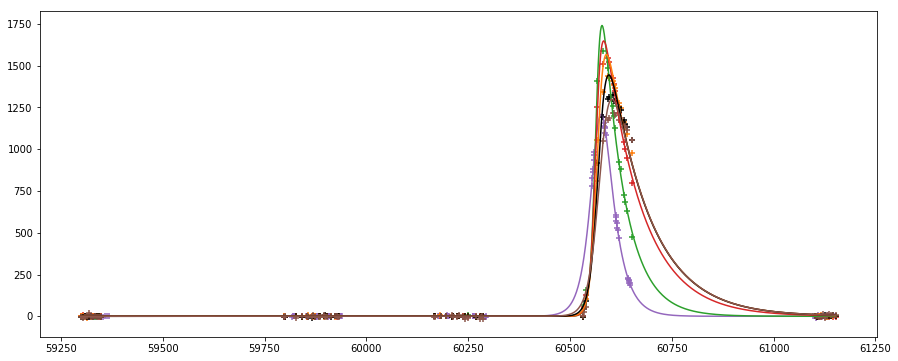

[60565.630139177236, 60565.02880869744, 60569.088195761404, 60572.984669640246]
t00 60567.359167469316
2429.15 31.54 median cov: -0
2079.92 65.39 median cov: -0
2085.05 96.49 median cov: -0
2108.88 100.00 median cov: -0
2009.08 100.00 median cov: -0
1876.79 100.00 median cov: -0


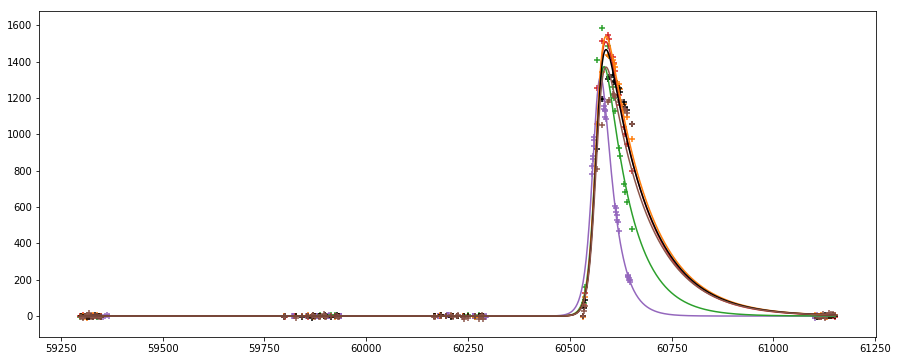

class 95 object_id =  31569
59820.1047 12 215.64447 0.9515000000028522
[571.4578455000001, 59815.1047, 5, 10]
[280.33781100000004, 59715.1047, 0.5, 1.0]
[862.57788, 59815.1047, 50, 100]
result: 426.92 59815.10 7.25 17.60 median cov: 0
59813.1122 21 297.759125 3.0
[789.06168125, 59808.1122, 5, 10]
[387.0868625, 59708.1122, 0.5, 1.0]
[1191.0365, 59808.1122, 50, 100]
result: 539.99 59804.76 6.92 30.53 median cov: 0
59813.1044 21 341.588257 2.9998999999952503
[905.20888105, 59808.1044, 5, 10]
[444.0647341, 59708.1044, 0.5, 1.0]
[1366.353028, 59808.1044, 50, 100]
result: 619.26 59806.90 7.82 38.82 median cov: 0
59813.1199 21 297.326355 2.9998999999952503
[787.9148407499999, 59808.1199, 5, 10]
[386.52426149999997, 59708.1199, 0.5, 1.0]
[1189.30542, 59808.1199, 50, 100]
result: 511.38 59806.17 7.98 52.36 median cov: 0
59835.0866 22 265.006622 21.95560000000114
[702.2675483, 59830.0866, 5, 10]
[344.5086086, 59730.0866, 0.5, 1.0]
[1060.026488, 59830.0866, 50, 100]
result: 415.22 59805.10 8.18 6

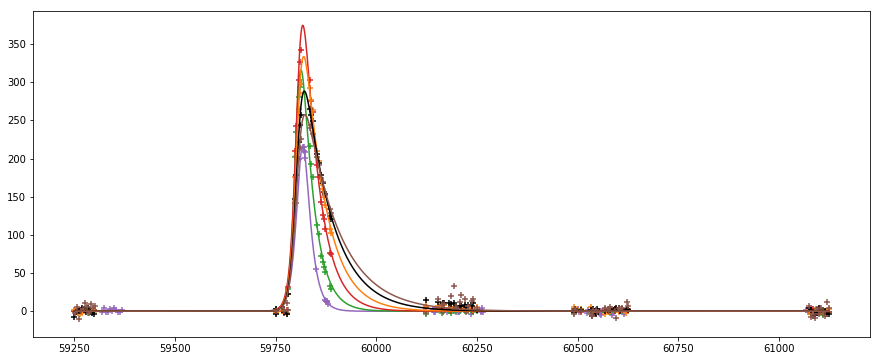

[59804.7563803044, 59806.90209960838, 59806.170307299464, 59805.09869753401]
t00 59805.63450241674
526.91 19.54 median cov: -0
539.22 30.42 median cov: -0
595.61 40.96 median cov: -0
503.04 53.72 median cov: -0
421.72 66.80 median cov: -0
365.69 79.01 median cov: -0


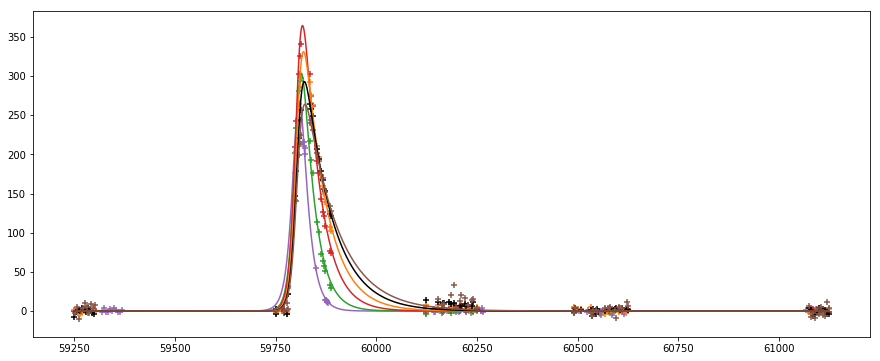

In [6]:
for class_ in [64, 88, 95]:
    print('class', class_)
    for object_id in train[train.target==class_].object_id.unique()[:5]:
        print('class', class_, end=' ')
        plot_bazin(object_id)